Github Repo: https://github.com/yitzhao/CS598_FTL_Trans/tree/main

Video Presentation: https://drive.google.com/file/d/19ERN9piQvd4khvqml5n2gVxqwLe2ERdT/view?usp=sharing   
GDrive Folder: https://drive.google.com/drive/folders/1plvfq7C7iA1rEZCnVqzNF48tM0uSq1Tt?usp=drive_link   (with checkpoints, but no mimic iii dataset)   


# Introduction
Clinical notes represent invaluable resources encapsulating a patient's health journey, offering vital insights for clinical decision-making. Despite their significance, current machine learning models frequently overlook the intricate sequential and temporal patterns embedded within these notes, leading to predictions that may not accurately reflect a patient's true clinical status. This oversight underscores the necessity for novel approaches capable of effectively integrating both sequential and temporal information from clinical notes to enhance predictive accuracy and facilitate more informed clinical decisions.

Time-Aware Transformer-based Network for Clinical Notes Series Prediction [1] proposed a novel hierarchical model structure, FTL-Trans, to overcome the aforementioned challenges by leveraging both the time and multi-level sequential information inherent in clinical notes. FTL-Trans consists of four successive layers: (1) Chunk Content Embedding Layer encodes each text chunk into an embedding, (2) Position-Enhanced Chunk Embedding Layer enriches the embedding with local and global position embedding,  (3) Time-Aware Layer implements Flexible Time-aware LSTM  and (4) Classification Layer generates the prediction.

Zhang et al. [1] showed that FTL-Trans consistently outperforms other state-of-the-art transformer-based architectures in their cohort of the MIMIC-III dataset. In our project, we will reproduce the main experiments and validate the efficacy of FTL-Trans in handling clinical notes and predicting healthcare tasks.


# Methodology

*  Chunk Content Embedding Layer
    * The Chunk Content Embedding Layer utilizes ClinicalBERT [3], a variation of BERT model pre-trained on medical text, to encode the textual content of each chunk within a patient's notes.

*  Position-Enhanced Chunk Embedding Layer
    * The Position-Enhanced Chunk Embedding Layer combines chunk content embedding with global and local position embeddings to form a unified representation. This embedding incorporates positional information about the note and chunk positions, enhancing the model's understanding of sequential structure.


*  Time-Aware Layer
    * The time-aware layer, consisting of the Flexible T-LSTM (FT-LSTM), an extension of the T-LSTM model [2], is designed for capturing the temporal information in the clinical note sequences to reflect the change of temporal importance of clinical events over time.
Compared to vanilla LSTM, FT-LSTM uses a flexible and universal decay function applied to short-term memory.

*  Classification Layer
    * The classification layer is simply a linear layer with sigmoid activation.


##  Data

  * MIMIC-III
    * We use MIMIC-III (Medical Information Mart for Intensive Care III) dataset for validation. MIMIC-III is comprised of de-identified health data associated with over 40,000 patients who stayed in intensive care units of the Beth Israel Deaconess Medical Center in Boston, MA, between 2001 and 2012. We perform experiment on two tasks in-hospital mortality prediction and 30-day readmission prediction.
  * Cohort
    * 30-day Readmission Prediction: Targeted patients re-admitted without scheduled appointments within 30 days following a prior discharge. The aim is to predict the likelihood of unplanned readmission. Three datasets are used to predict readmit.
      * Discharge summaries may contain information like a patient’s discharge condition, procedures, treatments, and significant findings. This means discharge summaries should have predictive value for hospital readmission.
      * Clinical Notes in the early stages of a patient’s admission are relevant to readmission prediction as well. We conduct 2 experiments to test model performance given notes up to 24–48h or 48–72h of a patient’s admission.
      * All Notes.


# Scope of Reproducibility:

In examining the code of the repo associated with [1]: https://github.com/zdy93/FTL-Trans/tree/master,
we observed multiple implementation and conceptual issues. In addition, when performing the experiment with the provided code, the model will simply not learn anything. While some of the implementation issues can be fixed, some conceptual issues make it very difficult for the approach to work properly.

Therefore, we provide our analysis on the issues and choose to build a similar hierachical models. The detailed analysis is in Model section.
## Ablation Study Using Existing Code: Time Decaying
We perform experiment usin the original code from https://github.com/zdy93/FTL-Trans/tree/master and compared it with a baseline when we force the time difference (input to time decay function) to be 1.
This is meant to be an ablation study to validate our claim that the design of time decay is problematic in [1].
## Reproduction of Flat Models baseline - ClinicalBERT, BERT
We perform the experiments validating the performance of the baseline flat models including ClinicalBERT and BERT. This also helps our own future implementation of hierachical model since they form the basis of the hierachy.

We use python 3.10 for our experiment. (Although other version will likely work just fine)

In [ ]:
!python3 --version

Python 3.10.12


We use google colab to run our experiment. We mainly need the the following packages:

In [ ]:
!pip3 freeze | grep transformer
!pip3 freeze | grep torch
!pip3 freeze | grep matplotlib
!pip3 freeze | grep pandas
!pip3 freeze | grep numpy

transformers==4.40.1
torch @ https://download.pytorch.org/whl/cu121/torch-2.2.1%2Bcu121-cp310-cp310-linux_x86_64.whl#sha256=1adf430f01ff649c848ac021785e18007b0714fdde68e4e65bd0c640bf3fb8e1
torchaudio @ https://download.pytorch.org/whl/cu121/torchaudio-2.2.1%2Bcu121-cp310-cp310-linux_x86_64.whl#sha256=23f6236429e2bf676b820e8e7221a1d58aaf908bff2ba2665aa852df71a97961
torchdata==0.7.1
torchsummary==1.5.1
torchtext==0.17.1
torchvision @ https://download.pytorch.org/whl/cu121/torchvision-0.17.1%2Bcu121-cp310-cp310-linux_x86_64.whl#sha256=27af47915f6e762c1d44e58e8088d22ac97445668f9f793524032b2baf4f34bd
matplotlib==3.7.1
matplotlib-inline==0.1.7
matplotlib-venn==0.11.10
geopandas==0.13.2
pandas==2.0.3
pandas-datareader==0.10.0
pandas-gbq==0.19.2
pandas-stubs==2.0.3.230814
sklearn-pandas==2.2.0
numpy==1.25.2


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
from transformers import AutoTokenizer
from tqdm import tqdm

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

import os
path = '/content/drive/MyDrive/FTL-Trans'
os.chdir(path)

Mounted at /content/drive


# Data Preprocessing
The following script expects MIMIC-III unzipped csv data located in ./DATA/

The scrip will generate three datasets of readmission prediction. At current stage, we have included statistical analysis and experiments on the discharge summary dataset as described above.


We use the admission and note events table from the MIMIC-III dataset. https://physionet.org/content/mimiciii/1.4/

In [ ]:
## We collect the data from MIMIC III dataset. https://physionet.org/content/mimiciii/1.4/
df_adm = pd.read_csv('DATA/ADMISSIONS.csv')
df_notes = pd.read_csv('DATA/NOTEEVENTS.csv')

<ipython-input-4-ac212e6e6af4>:3: DtypeWarning: Columns (4,5) have mixed types. Specify dtype option on import or set low_memory=False.
  df_notes = pd.read_csv('DATA/NOTEEVENTS.csv')


Some analysis on the raw MIMIC-III data:

In [ ]:
print('The ADMISSIONS table has %d patients with %d admissions' % (df_adm['SUBJECT_ID'].nunique(),df_adm['HADM_ID'].nunique()))

The ADMISSIONS table has 46520 patients with 58976 admissions


In [ ]:
print('The NOTEEVENTS table has %d notes with %d categories' % (df_notes['ROW_ID'].nunique(),df_notes['CATEGORY'].nunique()))

The NOTEEVENTS table has 2083180 notes with 15 categories


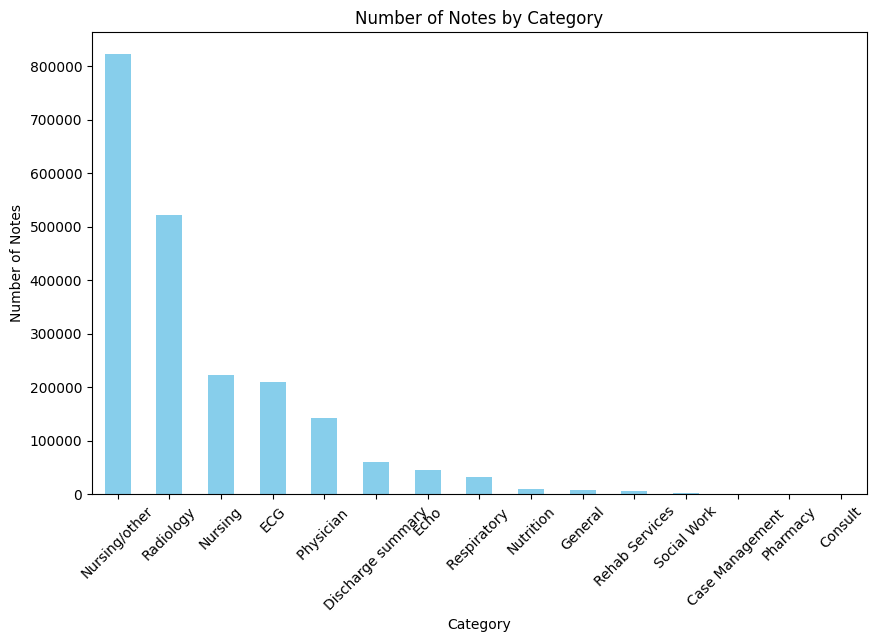

In [ ]:
# Count the occurrences of each category
category_counts = df_notes['CATEGORY'].value_counts()

# Sort the counts in descending order
category_counts = category_counts.sort_values(ascending=False)

# Plotting number of notes under each category
plt.figure(figsize=(10, 6))  # Adjust the size as necessary
category_counts.plot(kind='bar', color='skyblue')  # You can change the color
plt.title('Number of Notes by Category')
plt.xlabel('Category')
plt.ylabel('Number of Notes')
plt.xticks(rotation=45)  # Rotates the category names for better visibility
plt.show()

We begin the definition of functions used for data processing. In summary, main processes we perform include the following:
1. **Train-val-test** split with a ratio of 8:1:1
2. **Label balancing.** Since the number of negative samples are much larger than positive samples. We choose all the positive samples, and sample the same number of the negative samples from the negative sample pool.
3. **Text formatting.** E.g. removing of some de-identified buckets.

In [ ]:
## Data Process

### Text Cleaning
def preprocess1(x):
    y=re.sub('\\[(.*?)\\]','',x) #remove de-identified brackets
    y=re.sub('[0-9]+\.','',y) #remove 1.2. since the segmenter segments based on this
    y=re.sub('dr\.','doctor',y)
    y=re.sub('m\.d\.','md',y)
    y=re.sub('admission date:','',y)
    y=re.sub('discharge date:','',y)
    y=re.sub('--|__|==','',y)
    return y

### Split into Chunks
def preprocessing(df_less_n):
    df_less_n['TEXT']=df_less_n['TEXT'].fillna(' ')
    df_less_n['TEXT']=df_less_n['TEXT'].str.replace('\n',' ')
    df_less_n['TEXT']=df_less_n['TEXT'].str.replace('\r',' ')
    df_less_n['TEXT']=df_less_n['TEXT'].apply(str.strip)
    df_less_n['TEXT']=df_less_n['TEXT'].str.lower()

    df_less_n['TEXT']=df_less_n['TEXT'].apply(lambda x: preprocess1(x))

    #to get 318 words chunks for readmission tasks
    df_len = len(df_less_n)
    want=pd.DataFrame({'ID':[],'TEXT':[],'Label':[]})
    for i in tqdm(range(df_len)):
        x=df_less_n.TEXT.iloc[i].split()
        n=int(len(x)/318)
        for j in range(n):
            new_row = pd.DataFrame({
                      'TEXT': [' '.join(x[j*318:(j+1)*318])],
                      'Label': [df_less_n.OUTPUT_LABEL.iloc[i]],
                      'ID': [df_less_n.HADM_ID.iloc[i]]
                      })
            want = pd.concat([want, new_row], ignore_index=True)
        if len(x)%318>10:
            new_row = pd.DataFrame({
                      'TEXT': [' '.join(x[-(len(x)%318):])],
                      'Label': [df_less_n.OUTPUT_LABEL.iloc[i]],
                      'ID': [df_less_n.HADM_ID.iloc[i]]
                      })
            want = pd.concat([want, new_row], ignore_index=True)

    return want

## Create Dataset for Hierarchical Models
def preprocessing_chunks(df):
    tokenizer = AutoTokenizer.from_pretrained("emilyalsentzer/Bio_ClinicalBERT")
    df = df.rename(columns={'HADM_ID': "Adm_ID",
                            'ROW_ID': "Note_ID",
                            'CHARTDATE': "chartdate",
                            'CHARTTIME': "charttime",
                            'TEXT': "TEXT",
                            'OUTPUT_LABEL': "Label"})

    df['TEXT'] = df['TEXT'].fillna(' ')
    df['TEXT'] = df['TEXT'].str.replace('\n', ' ')
    df['TEXT'] = df['TEXT'].str.replace('\r', ' ')
    df['TEXT'] = df['TEXT'].apply(str.strip)
    df['TEXT'] = df['TEXT'].str.lower()

    df['TEXT'] = df['TEXT'].apply(lambda x: preprocess1(x))

    sen = df['TEXT'].values
    tokenized_texts = [tokenizer.tokenize(x) for x in sen]
    input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]
    df['Input_ID'] = input_ids
    df = df.astype({'Adm_ID': 'int64', 'Note_ID': 'int64', 'Label': 'int64'})
    return df[['Adm_ID', 'Note_ID', 'TEXT', 'Input_ID', 'Label', 'chartdate', 'charttime']]

def split_into_chunks(df, max_len):
    # Convert input IDs to strings, remove brackets, and split by comma
    input_ids = df['Input_ID'].apply(lambda x: ','.join(map(str, x)))
    input_ids = input_ids.str[1:-1].str.replace(' ', '').str.split(',')
    input_ids = input_ids.reset_index(drop=True)

    df_len = len(df)
    df = df.reset_index(drop=True)
    Adm_ID, Note_ID, Input_ID, Label, chartdate, charttime = [], [], [], [], [], []
    for i in tqdm(range(df_len)):
        x = input_ids[i]
        n = int(len(x) / (max_len - 2))
        for j in range(n):
            Adm_ID.append(df.Adm_ID[i])
            Note_ID.append(df.Note_ID[i])
            sub_ids = x[j * (max_len - 2): (j + 1) * (max_len - 2)]
            sub_ids.insert(0, '101')
            sub_ids.append('102')
            Input_ID.append(' '.join(sub_ids))
            Label.append(df.Label[i])
            chartdate.append(df.chartdate[i])
            charttime.append(df.charttime[i])
        if len(x) % (max_len - 2) > 10:
            Adm_ID.append(df.Adm_ID[i])
            Note_ID.append(df.Note_ID[i])
            sub_ids = x[-((len(x)) % (max_len - 2)):]
            sub_ids.insert(0, '101')
            sub_ids.append('102')
            Input_ID.append(' '.join(sub_ids))
            Label.append(df.Label[i])
            chartdate.append(df.chartdate[i])
            charttime.append(df.charttime[i])
    new_df = pd.DataFrame({'Adm_ID': Adm_ID,
                           'Note_ID': Note_ID,
                           'Input_ID': Input_ID,
                           'Label': Label,
                           'chartdate': chartdate,
                           'charttime': charttime})
    new_df = new_df.astype({'Adm_ID': 'int64', 'Note_ID': 'int64', 'Label': 'int64'})
    return new_df

### Admissions where a patient is readmitted within 30 days are labeled readmit = 1.
### All other patient admissions are labeled 0, including patients with appointments within 30 days (to model unexpected readmission).
def label_readmissions(df):
  df.ADMITTIME = pd.to_datetime(df.ADMITTIME, format = '%Y-%m-%d %H:%M:%S', errors = 'coerce')
  df.DISCHTIME = pd.to_datetime(df.DISCHTIME, format = '%Y-%m-%d %H:%M:%S', errors = 'coerce')
  df.DEATHTIME = pd.to_datetime(df.DEATHTIME, format = '%Y-%m-%d %H:%M:%S', errors = 'coerce')

  df = df.sort_values(['SUBJECT_ID','ADMITTIME'])
  df = df.reset_index(drop = True)
  df['NEXT_ADMITTIME'] = df.groupby('SUBJECT_ID').ADMITTIME.shift(-1)
  df['NEXT_ADMISSION_TYPE'] = df.groupby('SUBJECT_ID').ADMISSION_TYPE.shift(-1)

  rows = df.NEXT_ADMISSION_TYPE == 'ELECTIVE'
  df.loc[rows,'NEXT_ADMITTIME'] = pd.NaT
  df.loc[rows,'NEXT_ADMISSION_TYPE'] = np.NaN

  df = df.sort_values(['SUBJECT_ID','ADMITTIME'])

  #When we filter out the "ELECTIVE", we need to correct the next admit time for these admissions since there might be 'emergency' next admit after "ELECTIVE"
  df[['NEXT_ADMITTIME','NEXT_ADMISSION_TYPE']] = df.groupby(['SUBJECT_ID'])[['NEXT_ADMITTIME','NEXT_ADMISSION_TYPE']].fillna(method = 'bfill')
  df['DAYS_NEXT_ADMIT']=  (df.NEXT_ADMITTIME - df.DISCHTIME).dt.total_seconds()/(24*60*60)
  df['OUTPUT_LABEL'] = (df.DAYS_NEXT_ADMIT < 30).astype('int')
  ### filter out newborn and death
  df = df[df['ADMISSION_TYPE']!='NEWBORN']
  df = df[df.DEATHTIME.isnull()]
  df['DURATION'] = (df['DISCHTIME']-df['ADMITTIME']).dt.total_seconds()/(24*60*60)

  df.loc[df.DEATHTIME.notnull(), 'OUTPUT_LABEL'] = 0

  return df


### Merge Admissions with Noteevents Table
def merge_dataset(df_adm, df_note):
  df_note = df_note.sort_values(by=['SUBJECT_ID','HADM_ID','CHARTDATE'])
  df_adm_notes = pd.merge(df_adm[['SUBJECT_ID','HADM_ID','ADMITTIME','DISCHTIME','DAYS_NEXT_ADMIT','NEXT_ADMITTIME','ADMISSION_TYPE','DEATHTIME','OUTPUT_LABEL','DURATION']],
                          df_note[['SUBJECT_ID','HADM_ID','CHARTDATE','TEXT','CATEGORY','ROW_ID','CHARTTIME']],
                          on = ['SUBJECT_ID','HADM_ID'],
                          how = 'left')

  df_adm_notes['ADMITTIME_C'] = df_adm_notes['ADMITTIME'].apply(lambda x: str(x).split(' ')[0])
  df_adm_notes['ADMITTIME_C'] = pd.to_datetime(df_adm_notes.ADMITTIME_C, format = '%Y-%m-%d', errors = 'coerce')
  df_adm_notes['CHARTDATE'] = pd.to_datetime(df_adm_notes.CHARTDATE, format = '%Y-%m-%d', errors = 'coerce')

  return df_adm_notes

### Train/Val/Test Split
def split_dataset(df):
  ### Note that we divide on patient admission level and share among experiments, instead of notes level.
  ### This way, since our methods run on the same set of admissions, we can see the
  ### progression of readmission scores.

  readmit_ID = df[df.OUTPUT_LABEL == 1].HADM_ID
  not_readmit_ID = df[df.OUTPUT_LABEL == 0].HADM_ID
  #subsampling to get the balanced pos/neg numbers of patients for each dataset
  not_readmit_ID_use = not_readmit_ID.sample(n=len(readmit_ID), random_state=1)

  id_val_test_t = readmit_ID.sample(frac=0.2,random_state=1)
  id_val_test_f = not_readmit_ID_use.sample(frac=0.2,random_state=1)

  id_train_t = readmit_ID.drop(id_val_test_t.index)
  id_train_f = not_readmit_ID_use.drop(id_val_test_f.index)

  id_val_t=id_val_test_t.sample(frac=0.5,random_state=1)
  id_test_t=id_val_test_t.drop(id_val_t.index)

  id_val_f=id_val_test_f.sample(frac=0.5,random_state=1)
  id_test_f=id_val_test_f.drop(id_val_f.index)

  # test if there is overlap between train and test, should return "array([], dtype=int64)"
  print(len((pd.Index(id_test_t).intersection(pd.Index(id_train_t))).values))

  id_test = pd.concat([id_test_t, id_test_f])
  test_id_label = pd.DataFrame(data = list(zip(id_test, [1]*len(id_test_t)+[0]*len(id_test_f))), columns = ['id','label'])

  id_val = pd.concat([id_val_t, id_val_f])
  val_id_label = pd.DataFrame(data = list(zip(id_val, [1]*len(id_val_t)+[0]*len(id_val_f))), columns = ['id','label'])

  id_train = pd.concat([id_train_t, id_train_f])
  train_id_label = pd.DataFrame(data = list(zip(id_train, [1]*len(id_train_t)+[0]*len(id_train_f))), columns = ['id','label'])

  return readmit_ID, not_readmit_ID, not_readmit_ID_use, train_id_label, test_id_label, val_id_label

### Consruct dataset for readmission prediction using discharge summary
def get_discharge_dataset(df, readmit_ID, not_readmit_ID, not_readmit_ID_use, train_id_label, test_id_label, val_id_label, if_chunks):
  ### If Discharge Summary
  df_discharge = df[df['CATEGORY'] == 'Discharge summary']
  # multiple discharge summary for one admission -> after examination -> replicated summary -> replace with the last one
  df_discharge = (df_discharge.groupby(['SUBJECT_ID','HADM_ID']).nth(-1)).reset_index()
  df_discharge = df_discharge[df_discharge['TEXT'].notnull()]
  if not if_chunks:
    df_discharge = preprocessing(df_discharge)
    #get discharge train/val/test
    discharge_train = df_discharge[df_discharge.ID.isin(train_id_label.id)]
    discharge_val = df_discharge[df_discharge.ID.isin(val_id_label.id)]
    discharge_test = df_discharge[df_discharge.ID.isin(test_id_label.id)]
    # subsampling for training....since we obtain training on patient admission level so now we have same number of pos/neg readmission
    # but each admission is associated with different length of notes and we train on each chunks of notes, not on the admission, we need
    # to balance the pos/neg chunks on training set. (val and test set are fine) Usually, positive admissions have longer notes, so we need
    # find some negative chunks of notes from not_readmit_ID that we haven't used yet
    df_ID = pd.concat([not_readmit_ID_use, not_readmit_ID])
    df_ID = df_ID.drop_duplicates(keep=False)
    # for this set of split with random_state=1, we find we need 400 more negative training samples
    not_readmit_ID_more = df_ID.sample(n=400, random_state=1)
    discharge_train_snippets = pd.concat([df_discharge[df_discharge.ID.isin(not_readmit_ID_more)], discharge_train])
    #shuffle
    discharge_train_snippets = discharge_train_snippets.sample(frac=1, random_state=1).reset_index(drop=True)
  else:
    df_discharge = preprocessing_chunks(df_discharge[['HADM_ID','ROW_ID','CHARTDATE','CHARTTIME','TEXT','OUTPUT_LABEL']])
    #get discharge train/val/test
    discharge_train = df_discharge[df_discharge.Adm_ID.isin(train_id_label.id)]
    discharge_val = df_discharge[df_discharge.Adm_ID.isin(val_id_label.id)]
    discharge_test = df_discharge[df_discharge.Adm_ID.isin(test_id_label.id)]
    # subsampling for training....since we obtain training on patient admission level so now we have same number of pos/neg readmission
    # but each admission is associated with different length of notes and we train on each chunks of notes, not on the admission, we need
    # to balance the pos/neg chunks on training set. (val and test set are fine) Usually, positive admissions have longer notes, so we need
    # find some negative chunks of notes from not_readmit_ID that we haven't used yet
    df_ID = pd.concat([not_readmit_ID_use, not_readmit_ID])
    df_ID = df_ID.drop_duplicates(keep=False)
    # for this set of split with random_state=1, we find we need 400 more negative training samples
    not_readmit_ID_more = df_ID.sample(n=400, random_state=1)
    discharge_train_snippets = pd.concat([df_discharge[df_discharge.Adm_ID.isin(not_readmit_ID_more)], discharge_train])
    #shuffle
    discharge_train_snippets = discharge_train_snippets.sample(frac=1, random_state=1).reset_index(drop=True)
    discharge_train_snippets = split_into_chunks(discharge_train_snippets, 128)
    discharge_val = split_into_chunks(discharge_val, 128)
    discharge_test = split_into_chunks(discharge_test, 128)

  return discharge_train_snippets, discharge_val, discharge_test


### If Less than n days on admission notes (Early notes)
def less_n_days_data (df_adm_notes, n):

    df_less_n = df_adm_notes[((df_adm_notes['CHARTDATE']-df_adm_notes['ADMITTIME_C']).dt.total_seconds()/(24*60*60))<n]
    df_less_n=df_less_n[df_less_n['TEXT'].notnull()]
    #concatenate first
    df_concat = pd.DataFrame(df_less_n.groupby('HADM_ID')['TEXT'].apply(lambda x: "%s" % ' '.join(x))).reset_index()
    df_concat['OUTPUT_LABEL'] = df_concat['HADM_ID'].apply(lambda x: df_less_n[df_less_n['HADM_ID']==x].OUTPUT_LABEL.values[0])

    return df_concat

### If Less than n days on admission notes (Early notes, for chunks)
def less_n_days_data_chunks (df_adm_notes, n):
    df_less_n = df_adm_notes[((df_adm_notes['CHARTDATE']-df_adm_notes['ADMITTIME_C']).dt.total_seconds()/(24*60*60))<n]
    df_less_n = df_less_n[df_less_n['TEXT'].notnull()]

    return df_less_n

def get_early_notes_3_days_dataset(df, readmit_ID, not_readmit_ID, not_readmit_ID_use, train_id_label, test_id_label, val_id_label, if_chunks):
  if not if_chunks:
    df_less_2 = less_n_days_data(df, 2)
    df_less_3 = less_n_days_data(df, 3)
    df_less_2 = preprocessing(df_less_2)
    df_less_3 = preprocessing(df_less_3)
    ### for Early notes experiment: we only need to find training set for 3 days, then we can test
    ### both 3 days and 2 days. Since we split the data on patient level and experiments share admissions
    ### in order to see the progression, the 2 days training dataset is a subset of 3 days training set.
    ### So we only train 3 days and we can test/val on both 2 & 3days or any time smaller than 3 days. This means
    ### if we train on a dataset with all the notes in n days, we can predict readmissions smaller than n days.
    #for 3 days note, similar to discharge
    early_train = df_less_3[df_less_3.ID.isin(train_id_label.id)]

    df_ID = pd.concat([not_readmit_ID_use, not_readmit_ID])
    df_ID = df_ID.drop_duplicates(keep=False)
    not_readmit_ID_more = df_ID.sample(n=500, random_state=1)
    early_train_snippets = pd.concat([df_less_3[df_less_3.ID.isin(not_readmit_ID_more)], early_train])
    #shuffle
    early_train_snippets = early_train_snippets.sample(frac=1, random_state=1).reset_index(drop=True)
    early_val = df_less_3[df_less_3.ID.isin(val_id_label.id)]
    # we want to test on admissions that are not discharged already. So for less than 3 days of notes experiment,
    # we filter out admissions discharged within 3 days
    actionable_ID_3days = df[df['DURATION'] >= 3].HADM_ID
    test_actionable_id_label = test_id_label[test_id_label.id.isin(actionable_ID_3days)]
    early_test_3days = df_less_3[df_less_3.ID.isin(test_actionable_id_label.id)]
    #for 2 days notes, we only obtain test set. Since the model parameters are tuned on the val set of 3 days
    actionable_ID_2days = df[df['DURATION'] >= 2].HADM_ID
    test_actionable_id_label_2days = test_id_label[test_id_label.id.isin(actionable_ID_2days)]
    early_test_2days = df_less_2[df_less_2.ID.isin(test_actionable_id_label_2days.id)]
  else:
    df_less_2 = less_n_days_data_chunks(df, 2)
    df_less_3 = less_n_days_data_chunks(df, 3)
    df_less_2 = preprocessing_chunks(df_less_2[['HADM_ID','ROW_ID','CHARTDATE','CHARTTIME','TEXT','OUTPUT_LABEL']])
    df_less_3 = preprocessing_chunks(df_less_3[['HADM_ID','ROW_ID','CHARTDATE','CHARTTIME','TEXT','OUTPUT_LABEL']])
    early_train = df_less_3[df_less_3.Adm_ID.isin(train_id_label.id)]
    df_ID = pd.concat([not_readmit_ID_use, not_readmit_ID])
    df_ID = df_ID.drop_duplicates(keep=False)
    not_readmit_ID_more = df_ID.sample(n=500, random_state=1)
    early_train_snippets = pd.concat([df_less_3[df_less_3.Adm_ID.isin(not_readmit_ID_more)], early_train])
    #shuffle
    early_train_snippets = early_train_snippets.sample(frac=1, random_state=1).reset_index(drop=True)
    early_val = df_less_3[df_less_3.Adm_ID.isin(val_id_label.id)]
    # we want to test on admissions that are not discharged already. So for less than 3 days of notes experiment,
    # we filter out admissions discharged within 3 days
    actionable_ID_3days = df[df['DURATION'] >= 3].HADM_ID
    test_actionable_id_label = test_id_label[test_id_label.id.isin(actionable_ID_3days)]
    early_test_3days = df_less_3[df_less_3.Adm_ID.isin(test_actionable_id_label.id)]
    #for 2 days notes, we only obtain test set. Since the model parameters are tuned on the val set of 3 days
    actionable_ID_2days = df[df['DURATION'] >= 2].HADM_ID
    test_actionable_id_label_2days = test_id_label[test_id_label.id.isin(actionable_ID_2days)]
    early_test_2days = df_less_2[df_less_2.Adm_ID.isin(test_actionable_id_label_2days.id)]
    early_train_snippets = split_into_chunks(early_train_snippets, 128)
    early_val = split_into_chunks(early_val, 128)
    early_test_3days = split_into_chunks(early_test_3days, 128)
    early_test_2days = split_into_chunks(early_test_2days, 128)
  return early_train_snippets, early_val, early_test_3days, early_test_2days


In [ ]:
df_adm = label_readmissions(df_adm)

After merging the dataset, it's still not balanced. As shown in the following blocks:

In [ ]:
# Calculate value counts for the OUTPUT_LABEL column
output_counts = df_adm['OUTPUT_LABEL'].value_counts()

print(f"Number of Positive Readmission Labels: {output_counts.get(1,0)}")
print(f"Number of Negative Readmission Labels: {output_counts.get(0,0)}")

Number of Positive Readmission Labels: 2963
Number of Negative Readmission Labels: 42358


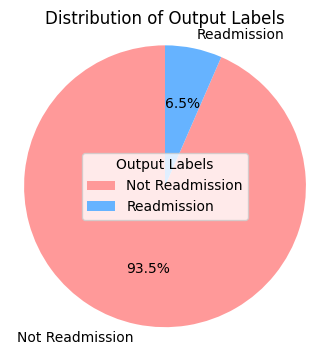

In [ ]:
# Labels for the legend
labels = ['Not Readmission', 'Readmission']

# Colors for the segments
colors = ['#ff9999','#66b3ff']  # Light red for Negative, Light blue for Positive

# Plotting the pie chart
plt.figure(figsize=(4, 4))  # Adjust the size as necessary
plt.pie(output_counts, labels=labels, autopct='%1.1f%%', startangle=90, colors=colors)
plt.title('Distribution of Output Labels')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

# Adding a legend
plt.legend(labels, title="Output Labels", loc="best")

plt.show()

In [ ]:
df = merge_dataset(df_adm, df_notes)

In [ ]:
print('The cohort has %d patients with %d admissions' % (df['SUBJECT_ID'].nunique(),df['HADM_ID'].nunique()))

The cohort has 34560 patients with 45321 admissions


In [ ]:
print('The cohort has %d notes with %d categories' % (df.shape[0],df['CATEGORY'].nunique()))

The cohort has 1202336 notes with 15 categories


In [ ]:
# Count the number of notes for each patient
notes_per_patient = df.groupby('SUBJECT_ID').size()

# Calculate the mean number of notes per patient
mean_notes_per_patient = notes_per_patient.mean()

print(f"Mean number of notes per patient: {mean_notes_per_patient:.2f}")

# Calculate the median number of notes per patient
median_notes_per_patient = notes_per_patient.median()

print(f"Median number of notes per patient: {median_notes_per_patient:.2f}")

Mean number of notes per patient: 34.79
Median number of notes per patient: 17.00


The train-val-test split and balancing is done inf the following two blocks.

In [ ]:
readmit_ID, not_readmit_ID, not_readmit_ID_use, train_id_label, test_id_label, val_id_label = split_dataset(df_adm)

0


In [ ]:
df_discharge_train, df_discharge_val, df_discharge_test = get_discharge_dataset(df, readmit_ID, not_readmit_ID, not_readmit_ID_use, train_id_label, test_id_label, val_id_label,False)

 79%|███████▉  | 34615/43880 [10:32<07:38, 20.22it/s]

In [ ]:
## Save discharge dataset to local
df_discharge_train.to_csv('DATA/discharge/train.csv')
df_discharge_val.to_csv('DATA/discharge/val.csv')
df_discharge_test.to_csv('DATA/discharge/test.csv')

In [ ]:
early_train_snippets, early_val, early_test_3days, early_test_2days = get_early_notes_3_days_dataset(df, readmit_ID, not_readmit_ID, not_readmit_ID_use, train_id_label, test_id_label, val_id_label, False)

100%|██████████| 44551/44551 [39:26<00:00, 18.82it/s]


In [ ]:
## Save 3 days early notes to local
early_train_snippets.to_csv('DATA/readmission_3days/train.csv')
early_val.to_csv('DATA/readmission_3days/val.csv')
early_test_3days.to_csv('DATA/readmission_3days/test.csv')

In [ ]:
## Save 2 days early notes to local
early_train_snippets.to_csv('DATA/readmission_2days/train.csv')
early_val.to_csv('DATA/readmission_2days/val.csv')
early_test_2days.to_csv('DATA/readmission_2days/test.csv')

In [ ]:
df_discharge_train_chunks, df_discharge_val_chunks, df_discharge_test_chunks = get_discharge_dataset(df, readmit_ID, not_readmit_ID, not_readmit_ID_use, train_id_label, test_id_label, val_id_label,True)

100%|██████████| 584/584 [00:00<00:00, 918.99it/s]


In [ ]:
## Save discharge dataset to local
df_discharge_train_chunks.to_csv('DATA/discharge_chunks/train.csv')
df_discharge_val_chunks.to_csv('DATA/discharge_chunks/val.csv')
df_discharge_test_chunks.to_csv('DATA/discharge_chunks/test.csv')

In [ ]:
early_train_snippets_chunks, early_val_chunks, early_test_3days_chunks, early_test_2days_chunks = get_early_notes_3_days_dataset(df, readmit_ID, not_readmit_ID, not_readmit_ID_use, train_id_label, test_id_label, val_id_label, True)

100%|██████████| 4631/4631 [00:00<00:00, 4778.52it/s]


In [ ]:
## Save 3 days early notes to local
early_train_snippets_chunks.to_csv('DATA/readmission_3days_chunks/train.csv')
early_val_chunks.to_csv('DATA/readmission_3days_chunks/val.csv')
early_test_3days_chunks.to_csv('DATA/readmission_3days_chunks/test.csv')

In [ ]:
## Save 2 days early notes to local
early_train_snippets_chunks.to_csv('DATA/readmission_2days_chunks/train.csv')
early_val_chunks.to_csv('DATA/readmission_2days_chunks/val.csv')
early_test_2days_chunks.to_csv('DATA/readmission_2days_chunks/test.csv')

## Dataset Generation for Hierachical BERT

The Hierachical BERT needs all discharge summaries for a single admission to perform prediction making its datase different from flat model such as ClinicalBERT.
The dataset can be generated by running https://github.com/yitzhao/CS598_FTL_Trans/blob/main/mimic_json.py after modifying the _DIR to specify output location

#   Model and Analysis
We include the following implementation from the repo of the paper [1].
We add our own annotation for the structure to be understandable. Yet, during our study of the model, we found multiples issues. We summarize them as the following:

**Poor Positional Embedding Design**
The embedding is a learned embedding which is used in vision transformer. However, vision transformer has a fixed number of patches for each image to apply the position embedding; therefore, the positional embedding of vision transformer at each position is equally and fully trained. However, when used for clinical notes and chunks of clinical notes. The number of positional embedding can vary largely such that the earlier positional embedding is trained a lot more than the later one. For patients with longer history, the positional embedding might barely be trained or not trained at all.

**Shared chunk position across different notes**
The chunk positional embedding is doesn't restart from 0 for each note. Therefore, It loses some ability such as representing the begining chunk of each note.


**Reusing weights between forward pass and backward pass in Bi-LSTM**
The implementation of FTLSTM uses the exact same parameter for the forward LSTM and backward LSTM. Consider that the forward and backward pass can include very differnet features, we believe this is a major flaw and can significantly hurt performance.


**Time Decay Design**
As implemented in map_elapse_time, the time decay is meant to help model learn the time difference between note chunks. However, since each note is splited into many chunk, the time difference t is mostly 0. Making the time difference very sparse and lack of information. In addition, these time difference also appear in the demominator of in the time decay function which further enlarges the problem.


Link to original Paper: https://proceedings.mlr.press/v126/zhang20c.html
Link to original Repo: https://github.com/zdy93/FTL-Trans
Link to Pretrained Model (ClinicalBert): https://github.com/kexinhuang12345/clinicalBERT

## FTL-Trans Implementation

In [ ]:
!pip install pytorch_transformers
from pytorch_transformers.modeling_bert import BertEmbeddings, BertEncoder, BertPooler, BertLayerNorm
import torch
from torch import nn
from torch.nn import init, Parameter
from torch.nn import CrossEntropyLoss, BCELoss, BCEWithLogitsLoss
import numpy as np

'''
The PatientLevelEmbedding provides embedding for chunk _id, note_id, and combine it with representation of BERT for each chunk of note.
The embedding is a learned embedding, similar to vision transformer.

We provide a forward example from the training set:

new_note_ids (Serves as positional embedding for notes):
tensor([1, 1, 0, 0, 0])
Similar to the segment_id of BERT, this positional embedding separate different notes. In this example, there are two notes
with position id 0 and 1.

new_chunk_ids (Serves as positional embedding for chunks):
tensor([4, 3, 2, 1, 0])
From the implementation from the author[1], this is simply a reserved python range function output since the chunk is ordered.
However, we believe this is problematic and chunk id should restart from 0 for each new note. ([1, 0, 2, 1, 0]) in this case.

inputs (Bert Representation):
tensor of shape (5, 768)
'''
class PatientLevelEmbedding(nn.Module):
    def __init__(self, config):
        super(PatientLevelEmbedding, self).__init__()
        self.config = config
        assert self.config.embed_mode in ["all", "note", "chunk", "no"]
        if self.config.embed_mode == "all":
            self.note_embedding = nn.Embedding(self.config.max_note_position_embedding, self.config.hidden_size)
            self.chunk_embedding = nn.Embedding(self.config.max_chunk_position_embedding, self.config.hidden_size)
            self.combine_embed_rep = nn.Linear(self.config.hidden_size * 3, self.config.hidden_size)
        elif self.config.embed_mode == "note":
            self.note_embedding = nn.Embedding(self.config.max_note_position_embedding, self.config.hidden_size)
            self.combine_embed_rep = nn.Linear(self.config.hidden_size * 2, self.config.hidden_size)
        elif self.config.embed_mode == "chunk":
            self.chunk_embedding = nn.Embedding(self.config.max_chunk_position_embedding, self.config.hidden_size)
            self.combine_embed_rep = nn.Linear(self.config.hidden_size * 2, self.config.hidden_size)
        else:
            pass
        self.LayerNorm = nn.LayerNorm(config.hidden_size, eps=config.layer_norm_eps)
        self.dropout = nn.Dropout(config.hidden_dropout_prob)

    def forward(self, inputs, new_note_ids=None, new_chunk_ids=None):
        if self.config.embed_mode == "all":
            note_embeds = self.note_embedding(new_note_ids)
            chunk_embeds = self.chunk_embedding(new_chunk_ids)
            output = self.combine_embed_rep(torch.cat((inputs, note_embeds, chunk_embeds), 2))
        elif self.config.embed_mode == "note":
            note_embeds = self.note_embedding(new_note_ids)
            output = self.combine_embed_rep(torch.cat((inputs, note_embeds), 2))
        elif self.config.embed_mode == "chunk":
            chunk_embeds = self.chunk_embedding(new_chunk_ids)
            output = self.combine_embed_rep(torch.cat((inputs, chunk_embeds), 2))
        elif self.config.embed_mode == "no":
            output = inputs
        else:
            raise ValueError("The embed mode: {} is not supported".format(self.config.embed_mode))
        if self.config.embed_mode != "no":
            output = self.LayerNorm(output)
            output = self.dropout(output)
        return output


'''
This is a wrapper of LSTM from torch.
It uses PatientLevelEmbedding defined above to combine the chunk and note positions with representation from BERT.
LSTM will go through these embedding to output a predition.

'''

class LSTMLayer(SelfDefineBert):
    def __init__(self, config, num_labels):
        super(LSTMLayer, self).__init__()
        self.config = config
        self.lstm = nn.LSTM(self.config.hidden_size,
                            self.config.hidden_size // 2,
                            self.config.lstm_layers,
                            batch_first=True,
                            bidirectional=True)
        self.dropout = nn.Dropout(self.config.hidden_dropout_prob)
        self.embeddings = PatientLevelEmbedding(config)
        self.classifier = nn.Linear(self.config.hidden_size, num_labels)

        self.apply(self.init_weights)

    def forward(self, inputs, new_note_ids=None, new_chunk_ids=None, labels=None):
        device = inputs.device
        batch_size = inputs.size()[0]
        hidden = (torch.zeros((self.config.lstm_layers * 2, batch_size, self.config.hidden_size // 2), device=device),
                  torch.zeros((self.config.lstm_layers * 2, batch_size, self.config.hidden_size // 2), device=device))
        new_input = self.embeddings(inputs, new_note_ids, new_chunk_ids)
        lstm_output, hidden = self.lstm(new_input, hidden)
        loss_fct = BCELoss()
        drop_input = lstm_output[0, -1, :]
        class_input = self.dropout(drop_input)
        logits = self.classifier(class_input)
        pred = torch.sigmoid(logits)
        if labels is not None:
            loss = loss_fct(pred, labels.float().view(1))
            return loss, pred
        else:
            return pred




'''
This is implementation of FTLSTM, the main idea in [1].
It's mostly an lstm with the map_elapse_time function adding a flexible time embedding as introduced in [1].
However, the implementation from the author uses same the weights for both direction.


'''



class FTLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, config, batch_first=True, bidirectional=True):
        super(FTLSTM, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.batch_first = batch_first
        self.bidirectional = bidirectional
        self.c1 = torch.Tensor([1]).float()
        self.c2 = torch.Tensor([np.e]).float()
        self.c3 = torch.Tensor([0.]).float()
        self.ones = torch.ones([1, self.hidden_size]).float()
        self.register_buffer('c1_const', self.c1)
        self.register_buffer('c2_const', self.c2)
        self.register_buffer('c3_const', self.c3)
        self.register_buffer("ones_const", self.ones)
        # Input Gate Parameter
        self.Wi = Parameter(torch.normal(0.0, config.initializer_range, size=(self.input_size, self.hidden_size)))
        self.Ui = Parameter(torch.normal(0.0, config.initializer_range, size=(self.hidden_size, self.hidden_size)))
        self.bi = Parameter(torch.zeros(self.hidden_size))
        # Forget Gate Parameter
        self.Wf = Parameter(torch.normal(0.0, config.initializer_range, size=(self.input_size, self.hidden_size)))
        self.Uf = Parameter(torch.normal(0.0, config.initializer_range, size=(self.hidden_size, self.hidden_size)))
        self.bf = Parameter(torch.zeros(self.hidden_size))
        # Output Gate Parameter
        self.Wog = Parameter(torch.normal(0.0, config.initializer_range, size=(self.input_size, self.hidden_size)))
        self.Uog = Parameter(torch.normal(0.0, config.initializer_range, size=(self.hidden_size, self.hidden_size)))
        self.bog = Parameter(torch.zeros(self.hidden_size))
        # Cell Layer Parameter
        self.Wc = Parameter(torch.normal(0.0, config.initializer_range, size=(self.input_size, self.hidden_size)))
        self.Uc = Parameter(torch.normal(0.0, config.initializer_range, size=(self.hidden_size, self.hidden_size)))
        self.bc = Parameter(torch.zeros(self.hidden_size))
        # Decomposition Layer Parameter
        self.W_decomp = Parameter(
            torch.normal(0.0, config.initializer_range, size=(self.hidden_size, self.hidden_size)))
        self.b_decomp = Parameter(torch.zeros(self.hidden_size))
        # Decay Parameter
        self.W_decay_1 = Parameter(torch.tensor([[0.33]]))
        self.W_decay_2 = Parameter(torch.tensor([[0.33]]))
        self.W_decay_3 = Parameter(torch.tensor([[0.33]]))
        self.a = Parameter(torch.tensor([1.0]))
        self.b = Parameter(torch.tensor([1.0]))
        self.m = Parameter(torch.tensor([0.02]))
        self.k = Parameter(torch.tensor([2.9]))
        self.d = Parameter(torch.tensor([4.5]))
        self.n = Parameter(torch.tensor([2.5]))

    def FTLSTM_unit(self, prev_hidden_memory, inputs, times):
        prev_hidden_state, prev_cell = prev_hidden_memory
        x = inputs
        t = times
        T = self.map_elapse_time(t)
        C_ST = torch.tanh(torch.matmul(prev_cell, self.W_decomp) + self.b_decomp)
        C_ST_dis = torch.mul(T, C_ST)
        prev_cell = prev_cell - C_ST + C_ST_dis

        # Input Gate
        i = torch.sigmoid(torch.matmul(x, self.Wi) +
                          torch.matmul(prev_hidden_state, self.Ui) + self.bi)
        # Forget Gate
        f = torch.sigmoid(torch.matmul(x, self.Wf) +
                          torch.matmul(prev_hidden_state, self.Uf) + self.bf)
        # Output Gate
        o = torch.sigmoid(torch.matmul(x, self.Wog) +
                          torch.matmul(prev_hidden_state, self.Uog) + self.bog)
        # Candidate Memory Cell
        C = torch.sigmoid(torch.matmul(x, self.Wc) +
                          torch.matmul(prev_hidden_state, self.Uc) + self.bc)
        # Current Memory Cell
        Ct = f * prev_cell + i * C

        # Current Hidden State
        current_hidden_state = o * torch.tanh(Ct)

        return current_hidden_state, Ct

    def map_elapse_time(self, t):
        T_1 = torch.div(self.c1_const, torch.mul(self.a, torch.pow(t, self.b)))
        T_2 = self.k - torch.mul(self.m, t)
        T_3 = torch.div(self.c1_const, (self.c1_const + torch.pow(torch.div(t, self.d), self.n)))
        T = torch.mul(self.W_decay_1, T_1) + torch.mul(self.W_decay_2, T_2) + torch.mul(self.W_decay_3, T_3)
        T = torch.max(T, self.c3_const)
        T = torch.min(T, self.c1_const)
        T = torch.matmul(T, self.ones_const)
        return T

    def forward(self, inputs, times):
        device = inputs.device
        if self.batch_first:
            batch_size = inputs.size()[0]
            inputs = inputs.permute(1, 0, 2)
            times = times.transpose(0, 1)
        else:
            batch_size = inputs.size()[1]
        prev_hidden = torch.zeros((batch_size, self.hidden_size), device=device)
        prev_cell = torch.zeros((batch_size, self.hidden_size), device=device)
        seq_len = inputs.size()[0]
        hidden_his = []
        for i in range(seq_len):
            prev_hidden, prev_cell = self.FTLSTM_unit((prev_hidden, prev_cell), inputs[i], times[i])
            hidden_his.append(prev_hidden)
        hidden_his = torch.stack(hidden_his)
        if self.bidirectional:
            second_hidden = torch.zeros((batch_size, self.hidden_size), device=device)
            second_cell = torch.zeros((batch_size, self.hidden_size), device=device)
            second_inputs = torch.flip(inputs, [0])
            second_times = torch.flip(times, [0])
            second_hidden_his = []
            for i in range(seq_len):
                if i == 0:
                    time = times[i]
                else:
                    time = second_times[i-1]
                second_hidden, second_cell = self.FTLSTM_unit((second_hidden, second_cell), second_inputs[i], time)
                second_hidden_his.append(second_hidden)
            second_hidden_his = torch.stack(second_hidden_his)
            hidden_his = torch.cat((hidden_his, second_hidden_his), dim=2)
            prev_hidden = torch.cat((prev_hidden, second_hidden), dim=1)
            prev_cell = torch.cat((prev_cell, second_cell), dim=1)
        if self.batch_first:
            hidden_his = hidden_his.permute(1, 0, 2)
        return hidden_his, (prev_hidden, prev_cell)



'''
FTLSTMLayer is a wrapper function of FTLSTM.
It uses PatientLevelEmbedding defined above as embedding and a classifer for final prediction output.

'''

class FTLSTMLayer(SelfDefineBert):

    def __init__(self, config, num_labels):
        super(FTLSTMLayer, self).__init__()
        self.config = config
        self.ftlstm = FTLSTM(self.config.hidden_size,
                           self.config.hidden_size // 2,
                           self.config,
                           batch_first=True,
                           bidirectional=True)
        self.dropout = nn.Dropout(self.config.hidden_dropout_prob)
        self.embeddings = PatientLevelEmbedding(config)
        self.classifier = nn.Linear(self.config.hidden_size, num_labels)

        self.apply(self.init_weights)

    def forward(self, inputs, times, new_note_ids=None, new_chunk_ids=None, labels=None):
        new_input = self.embeddings(inputs, new_note_ids, new_chunk_ids)
        lstm_output, hidden = self.ftlstm(new_input, times.float())
        loss_fct = BCEWithLogitsLoss()
        drop_input = lstm_output[0, -1, :]
        class_input = self.dropout(drop_input)
        logits = self.classifier(class_input)
        logits = torch.where(torch.isnan(logits), torch.zeros_like(logits), logits)
        logits = torch.where(torch.isinf(logits), torch.zeros_like(logits), logits)
        pred = torch.sigmoid(logits)
        pred = torch.where(torch.isnan(pred), torch.zeros_like(pred), pred)
        pred = torch.where(torch.isinf(pred), torch.zeros_like(pred), pred)
        if labels is not None:
            loss = loss_fct(logits, labels.float().view(1))
            return loss, pred
        else:
            return pred


## Hierachical BERT

In [ ]:
import torch
from torch import nn
from transformers import AutoTokenizer, BertForSequenceClassification, BertModel
from torch.nn import LSTM
from tqdm import tqdm

class HierchicalBERT(nn.Module):
    def __init__(self, num_of_labels):
        super(HierchicalBERT, self).__init__()
        self.bert = BertModel.from_pretrained("emilyalsentzer/Bio_ClinicalBERT")
        self.rnn = LSTM(input_size=768, hidden_size=768, num_layers=2, bidirectional=True, batch_first=True)
        self.fc = nn.Linear(1536, num_of_labels)
    def forward(self, input_ids, attention_mask, **kwargs):
        outputs = self.bert(input_ids, attention_mask)
        representations = outputs.last_hidden_state[:, 0, :]
        lstm_out = self.rnn(representations.unsqueeze(1))
        last_lstm_hidden = lstm_out[0][-1, :, :]
        res = self.fc(last_lstm_hidden)
        res = torch.softmax(res, dim=1)
        return res

# Training
## Computational Requirements
Due to the size of our cohort being small. Our training will generally take around 1 hr and half on a budget GPU such as Quadro RTX 5000 or T4 for 3 epoches (30 minutes per epoch) training on a single model. In total, we ran 6 experiments.


We incorporated the training of BERT and ClinicalBERT with huggingface model as a baseline for our experiments.

## Hyperparameters
```
learning rate = 1e-3
max_seq_length = 512
train_batch_size = 8
num_train_epochs = 3
eval_batch_size = 8
```

In [ ]:
import torch
import json
import time
import csv
from tqdm import tqdm
from pprint import pprint
from torch.multiprocessing import Pool, Process, set_start_method, current_process, freeze_support
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer, AutoModelForCausalLM
from scipy import interp
from tqdm import trange, tqdm
from sklearn.metrics import roc_auc_score, precision_recall_curve, roc_curve, auc, confusion_matrix, classification_report
from inspect import signature
import matplotlib.pyplot as plt

import pandas as pd
import numpy as np
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from torch.utils.data.distributed import DistributedSampler
from torch import nn

class InputExample(object):
    """A single training/test example for simple sequence classification."""
    def __init__(self, guid, text_a, text_b=None, label=None):
        """Constructs a InputExample.
        Args:
            guid: Unique id for the example.
            text_a: string. The untokenized text of the first sequence. For single
            sequence tasks, only this sequence must be specified.
            text_b: (Optional) string. The untokenized text of the second sequence.
            Only must be specified for sequence pair tasks.
            label: (Optional) string. The label of the example. This should be
            specified for train and dev examples, but not for test examples.
        """
        self.guid = guid
        self.text_a = text_a
        self.text_b = text_b
        self.label = label


class InputFeatures(object):
    """A single set of features of data."""
    def __init__(self, input_ids, input_mask, segment_ids, label_id):
        self.input_ids = input_ids
        self.input_mask = input_mask
        self.segment_ids = segment_ids
        self.label_id = label_id

class readmissionProcessor(object):
    def get_train_examples(self, data_dir):
        print("LOOKING AT {}".format(os.path.join(data_dir, "train.csv")))
        return self._create_examples(
            self._read_csv(os.path.join(data_dir, "train.csv")), "train")
    def get_dev_examples(self, data_dir):
        return self._create_examples(
            self._read_csv(os.path.join(data_dir, "val.csv")), "val")
    def get_test_examples(self, data_dir):
        return self._create_examples(
            self._read_csv(os.path.join(data_dir, "test.csv")), "test")
    def get_labels(self):
        return ["0", "1"]
    def _create_examples(self, lines, set_type):
        """Creates examples for the training and dev sets."""
        examples = []
        for (i, line) in enumerate(lines):
            guid = "%s-%s" % (set_type, i)
            text_a = line[1]
            label = str(int(line[2]))
            examples.append(
                InputExample(guid=guid, text_a=text_a, text_b=None, label=label))
        return examples
    @classmethod
    def _read_tsv(cls, input_file, quotechar=None):
        """Reads a tab separated value file."""
        with open(input_file, "r") as f:
            reader = csv.reader(f, delimiter="\t", quotechar=quotechar)
            lines = []
            for line in reader:
                lines.append(line)
            return lines
    @classmethod
    def _read_csv(cls, input_file):
        """Reads a comma separated value file."""
        file=pd.read_csv(input_file)
        lines=zip(file.ID,file.TEXT,file.Label)
        return lines

def convert_examples_to_features(examples, label_list, max_seq_length, tokenizer):
    """Loads a data file into a list of `InputBatch`s."""
    label_map = {}
    for (i, label) in enumerate(label_list):
        label_map[label] = i
    features = []
    for (ex_index, example) in tqdm(enumerate(examples)):
        # print('example.text_a')
        # print(example.text_a)
        if type(example.text_a) != str:
            continue
        tokens_a = tokenizer.tokenize(example.text_a)
        tokens_b = None
        if example.text_b:
            tokens_b = tokenizer.tokenize(example.text_b)
        if tokens_b:
            # Modifies `tokens_a` and `tokens_b` in place so that the total
            # length is less than the specified length.
            # Account for [CLS], [SEP], [SEP] with "- 3"
            _truncate_seq_pair(tokens_a, tokens_b, max_seq_length - 3)
        else:
            # Account for [CLS] and [SEP] with "- 2"
            if len(tokens_a) > max_seq_length - 2:
                tokens_a = tokens_a[0:(max_seq_length - 2)]
        # The convention in BERT is:
        # (a) For sequence pairs:
        #  tokens:   [CLS] is this jack ##son ##ville ? [SEP] no it is not . [SEP]
        #  type_ids: 0   0  0    0    0     0       0 0    1  1  1  1   1 1
        # (b) For single sequences:
        #  tokens:   [CLS] the dog is hairy . [SEP]
        #  type_ids: 0   0   0   0  0     0 0
        #
        # Where "type_ids" are used to indicate whether this is the first
        # sequence or the second sequence. The embedding vectors for `type=0` and
        # `type=1` were learned during pre-training and are added to the wordpiece
        # embedding vector (and position vector). This is not *strictly* necessary
        # since the [SEP] token unambigiously separates the sequences, but it makes
        # it easier for the model to learn the concept of sequences.
        #
        # For classification tasks, the first vector (corresponding to [CLS]) is
        # used as as the "sentence vector". Note that this only makes sense because
        # the entire model is fine-tuned.
        tokens = []
        segment_ids = []
        tokens.append("[CLS]")
        segment_ids.append(0)
        for token in tokens_a:
            tokens.append(token)
            segment_ids.append(0)
        tokens.append("[SEP]")
        segment_ids.append(0)
        if tokens_b:
            for token in tokens_b:
                tokens.append(token)
                segment_ids.append(1)
            tokens.append("[SEP]")
            segment_ids.append(1)
        input_ids = tokenizer.convert_tokens_to_ids(tokens)
        # The mask has 1 for real tokens and 0 for padding tokens. Only real
        # tokens are attended to.
        input_mask = [1] * len(input_ids)
        # Zero-pad up to the sequence length.
        while len(input_ids) < max_seq_length:
            input_ids.append(0)
            input_mask.append(0)
            segment_ids.append(0)
        assert len(input_ids) == max_seq_length
        assert len(input_mask) == max_seq_length
        assert len(segment_ids) == max_seq_length
        #print (example.label)
        label_id = label_map[example.label]
        if ex_index < 5:
            print("*** Example ***")
            print("guid: %s" % (example.guid))
            print("tokens: %s" % " ".join(
                    [str(x) for x in tokens]))
            print("input_ids: %s" % " ".join([str(x) for x in input_ids]))
            print("input_mask: %s" % " ".join([str(x) for x in input_mask]))
            print(
                    "segment_ids: %s" % " ".join([str(x) for x in segment_ids]))
            print("label: %s (id = %d)" % (example.label, label_id))
        features.append(
                InputFeatures(input_ids=input_ids,
                              input_mask=input_mask,
                              segment_ids=segment_ids,
                              label_id=label_id))
    return features



# train_features = convert_examples_to_features(
#     train_examples, label_list, max_seq_length, tokenizer)

def _truncate_seq_pair(tokens_a, tokens_b, max_length):
    """Truncates a sequence pair in place to the maximum length."""
    # This is a simple heuristic which will always truncate the longer sequence
    # one token at a time. This makes more sense than truncating an equal percent
    # of tokens from each, since if one sequence is very short then each token
    # that's truncated likely contains more information than a longer sequence.
    while True:
        total_length = len(tokens_a) + len(tokens_b)
        if total_length <= max_length:
            break
        if len(tokens_a) > len(tokens_b):
            tokens_a.pop()
        else:
            tokens_b.pop()

def accuracy(out, labels):
    outputs = out.argmax(dim=-1)
    return (outputs == labels).float().mean().item()

def vote_score(df, score, readmission_mode, empty=None):
    df['pred_score'] = score
    df_sort = df.sort_values(by=['ID'])
    #score
    temp = (df_sort.groupby(['ID'])['pred_score'].agg(max)+df_sort.groupby(['ID'])['pred_score'].agg(sum)/2)/(1+df_sort.groupby(['ID'])['pred_score'].agg(len)/2)
    x = df_sort.groupby(['ID'])['Label'].agg(np.min).values
    df_out = pd.DataFrame({'logits': temp.values, 'ID': x})
    fpr, tpr, thresholds = roc_curve(x, temp.values)
    auc_score = auc(fpr, tpr)
    plt.figure(1)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot(fpr, tpr, label='Val (area = {:.3f})'.format(auc_score))
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('ROC curve')
    plt.legend(loc='best')
    plt.show()
    string = 'auroc_clinicalbert_'+readmission_mode+'.png'
    plt.savefig(os.path.join(output_dir, string))
    return fpr, tpr, df_out

def pr_curve_plot(y, y_score, readmission_mode, empty=None):
    precision, recall, _ = precision_recall_curve(y, y_score)
    area = auc(recall,precision)
    step_kwargs = ({'step': 'post'}
                   if 'step' in signature(plt.fill_between).parameters
                   else {})
    plt.figure(2)
    plt.step(recall, precision, color='b', alpha=0.2,
             where='post')
    plt.fill_between(recall, precision, alpha=0.2, color='b', **step_kwargs)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title('Precision-Recall curve: AUC={0:0.2f}'.format(
              area))
    string = 'auprc_clinicalbert_'+readmission_mode+'.png'
    plt.savefig(os.path.join(output_dir, string))


def vote_pr_curve(df, score, empty=None):
    df['pred_score'] = score
    df_sort = df.sort_values(by=['ID'])
    #score
    temp = (df_sort.groupby(['ID'])['pred_score'].agg(max)+df_sort.groupby(['ID'])['pred_score'].agg(sum)/2)/(1+df_sort.groupby(['ID'])['pred_score'].agg(len)/2)
    y = df_sort.groupby(['ID'])['Label'].agg(np.min).values
    precision, recall, thres = precision_recall_curve(y, temp)
    pr_thres = pd.DataFrame(data =  list(zip(precision, recall, thres)), columns = ['prec','recall','thres'])
    vote_df = pd.DataFrame(data =  list(zip(temp, y)), columns = ['score','label'])
    pr_curve_plot(y, temp, empty)
    temp = pr_thres[pr_thres.prec > 0.799999].reset_index()
    rp80 = 0
    if temp.size == 0:
        print('Test Sample too small or RP80=0')
    else:
        rp80 = temp.iloc[0].recall
        print('Recall at Precision of 80 is {}', rp80)
    return rp80

In [ ]:
import torch
from torch.utils.data import DataLoader, RandomSampler, TensorDataset
from tqdm import trange
import matplotlib.pyplot as plt
from transformers import Adafactor
import os

def train_model(model, tokenizer, data_dir, num_labels, device, lr, train_batch_size, num_train_epochs, max_seq_length):
  optimizer = Adafactor(params = model.parameters(), lr=lr, relative_step=False)
  model.train()
  all_losses = []
  global_step = 0
  train_loss=100000
  number_training_steps=1
  global_step_check=0
  train_loss_history=[]
  processor = readmissionProcessor()
  label_list = processor.get_labels()
  train_examples = processor.get_train_examples(data_dir)
  num_train_steps = int(
      len(train_examples) / train_batch_size / num_train_epochs)

  train_features = convert_examples_to_features(
    train_examples, label_list, max_seq_length, tokenizer)
  print("***** Running training *****")
  print("  Num examples = %d", len(train_examples))
  print("  Batch size = %d", train_batch_size)
  print("  Num steps = %d", num_train_steps)
  all_input_ids = torch.tensor([f.input_ids for f in train_features], dtype=torch.long)
  all_input_mask = torch.tensor([f.input_mask for f in train_features], dtype=torch.long)
  all_segment_ids = torch.tensor([f.segment_ids for f in train_features], dtype=torch.long)
  all_label_ids = torch.tensor([f.label_id for f in train_features], dtype=torch.long)
  train_data = TensorDataset(all_input_ids, all_input_mask, all_segment_ids, all_label_ids)
  train_sampler = RandomSampler(train_data)
  train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=train_batch_size)

  all_loss = []
  all_acc = []

  model.train()
  for epo in trange(int(num_train_epochs), desc="Epoch"):
    tr_loss = 0
    nb_tr_examples, nb_tr_steps = 0, 0
    for step, batch in enumerate(train_dataloader):
        batch = tuple(t.to(device) for t in batch)
        input_ids, input_mask, segment_ids, label_ids = batch
        pred = model(input_ids, attention_mask=input_mask, labels=label_ids.unsqueeze(1))
        loss = pred.loss
        logits = pred.logits
        training_acc = accuracy(logits.detach().cpu(), label_ids.detach().cpu())
        loss.backward()
        train_loss_history.append(loss.item())
        tr_loss += loss.item()
        nb_tr_examples += input_ids.size(0)
        nb_tr_steps += 1
        optimizer.step()
        model.zero_grad()
        global_step += 1
        all_loss.append(loss.item())
        all_acc.append(training_acc)
        if (step+1) % 200 == 0:
            print('Epoch: {}, Step: {}, Loss: {}, Acc: {}'.format(epo, step, sum(all_loss[-200:])/len(all_loss[-200:]), sum(all_acc[-200:])/len(all_loss[-200:])))

  train_loss = tr_loss
  global_step_check = global_step
  number_training_steps = nb_tr_steps

  # string = './pytorch_model_new_'+readmission_mode+'.bin'
  # torch.save(model.state_dict(), string)

  fig1 = plt.figure()
  plt.plot(train_loss_history)
  fig1.savefig('loss_history.png', dpi=fig1.dpi)

  return model, train_loss, global_step_check, number_training_steps


In [ ]:
from torch.utils.data import DataLoader, SequentialSampler, TensorDataset
from tqdm import tqdm
import pandas as pd
import numpy as np
from sklearn.metrics import roc_auc_score, precision_recall_curve, auc

def evaluate_model(model, tokenizer, data_dir, max_seq_length, eval_batch_size, device, readmission_mode, output_dir):
  m = nn.Sigmoid()
  processor = readmissionProcessor()
  label_list = processor.get_labels()
  eval_examples = processor.get_test_examples(data_dir)
  eval_features = convert_examples_to_features(
      eval_examples, label_list, max_seq_length, tokenizer)
  print("***** Running evaluation *****")
  print("  Num examples = %d", len(eval_examples))
  print("  Batch size = %d", eval_batch_size)
  all_input_ids = torch.tensor([f.input_ids for f in eval_features], dtype=torch.long)
  all_input_mask = torch.tensor([f.input_mask for f in eval_features], dtype=torch.long)
  all_segment_ids = torch.tensor([f.segment_ids for f in eval_features], dtype=torch.long)
  all_label_ids = torch.tensor([f.label_id for f in eval_features], dtype=torch.long)
  eval_data = TensorDataset(all_input_ids, all_input_mask, all_segment_ids, all_label_ids)
  eval_sampler = SequentialSampler(eval_data)
  eval_dataloader = DataLoader(eval_data, sampler=eval_sampler, batch_size=eval_batch_size)
  model.eval()
  eval_loss, eval_accuracy = 0, 0
  nb_eval_steps, nb_eval_examples = 0, 0
  true_labels=[]
  pred_labels=[]
  logits_history=[]
  for input_ids, input_mask, segment_ids, label_ids in tqdm(eval_dataloader):
    input_ids = input_ids.to(device)
    input_mask = input_mask.to(device)
    segment_ids = segment_ids.to(device)
    label_ids = label_ids.to(device)
    with torch.no_grad():
        output = model(input_ids, token_type_ids=segment_ids, attention_mask=input_mask, labels=label_ids)
        tmp_eval_loss, logits = output[:2]

    logits = torch.squeeze(m(logits[:,1])).detach().cpu().numpy()
    label_ids = label_ids.to('cpu').numpy()
    outputs = np.asarray([1 if i else 0 for i in (logits.flatten()>=0.5)])
    tmp_eval_accuracy=np.sum(outputs == label_ids)
    true_labels = true_labels + label_ids.flatten().tolist()
    pred_labels = pred_labels + outputs.flatten().tolist()
    logits_history = logits_history + logits.flatten().tolist()
    eval_loss += tmp_eval_loss.mean().item()
    eval_accuracy += tmp_eval_accuracy
    nb_eval_examples += input_ids.size(0)
    nb_eval_steps += 1

  eval_loss = eval_loss / nb_eval_steps
  eval_accuracy = eval_accuracy / nb_eval_examples
  df = pd.DataFrame({'logits':logits_history, 'pred_label': pred_labels, 'label':true_labels})
  string = 'logits_clinicalbert_'+readmission_mode+'_chunks.csv'
  df.to_csv(os.path.join(output_dir, string))
  df_test = pd.read_csv(os.path.join(data_dir, "test.csv"))

  # Drop na for df_test
  df_test = df_test.dropna()

  fpr, tpr, df_out = vote_score(df_test, logits_history,readmission_mode)
  #auc_score = get_auc_score(df_test, logits_history)
  # Convert logits_history to probabilities
  probabilities = [1 / (1 + np.exp(-x)) for x in logits_history]
  # Calculate AUC
  auc_score = roc_auc_score(true_labels, probabilities)
  # Calculate precision-recall curve, then calculate AUPRC
  precision, recall, _ = precision_recall_curve(true_labels, probabilities)
  auprc_score = auc(recall, precision)
  string = 'logits_clinicalbert_'+readmission_mode+'_readmissions.csv'
  df_out.to_csv(os.path.join(output_dir,string))
  rp80 = vote_pr_curve(df_test, logits_history,readmission_mode)
  result = {'eval_loss': eval_loss,
            'eval_accuracy': eval_accuracy,
            'auc_score': auc_score,
            'auprc_score':auprc_score,
            'RP80': rp80}

  return result

In [ ]:
def evaluate_hierachical(test):
    hierachical_bert.eval()
    with torch.no_grad():
        all_losses = []
        all_acc = []
        all_prob = []
        all_labels = []
        for i, item in enumerate(tqdm(test)):
            all_tokens = flatten_list_of_list_of_tokens(item['tokens'])
            all_tokens, attention_mask = list_of_tokens_to_tensor(all_tokens)
            label = torch.tensor([int(item['Label'])]).to(device)
            outputs = hierachical_bert(all_tokens.to(device), attention_mask.to(device))
            all_prob.append(outputs[0][0].item())
            loss = criteria(outputs, label)
            all_losses.append(loss.item())
            all_acc.append((outputs.argmax(-1)[0] == label).item())
            all_labels.append(label.item())
        print('============================================')
        print(f'Evaluation loss: {sum(all_losses)/len(all_losses)}, acc: {sum(all_acc)/len(all_acc)}')
    auc_score = roc_auc_score(all_labels, all_prob)
    precision, recall, _ = precision_recall_curve(all_labels, all_prob)
    auprc_score = auc(recall, precision)
    eval_loss = sum(all_losses)/len(all_losses)
    eval_accuracy = sum(all_acc)/len(all_acc)
    hierachical_bert.train()
    return {
        'eval_loss': eval_loss,
        'eval_accuracy': eval_accuracy,
        'auc_score': auc_score,
        'auprc_score': auprc_score
    }

### Flat Model Experiments using Discharge Summary Cohort

#### Bert-based readmission prediction

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at google-bert/bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


LOOKING AT DATA/discharge/train.csv


0it [00:00, ?it/s]Token indices sequence length is longer than the specified maximum sequence length for this model (562 > 512). Running this sequence through the model will result in indexing errors
119it [00:00, 590.15it/s]

*** Example ***
guid: train-0
tokens: [CLS] l ##v cavity size . normal regional l ##v sy ##sto ##lic function . hyper ##dy ##nami ##c l ##ve ##f > 75 % . mid - ca ##vita ##ry gradient . no vs ##d . right vent ##ric ##le : normal rv chamber size and free wall motion . ao ##rta : mildly dil ##ated ascending ao ##rta . ao ##rti ##c valve : three ao ##rti ##c valve leaflets . moderately thick ##ened ao ##rti ##c valve leaflets . mild as ( area 2 - 9 ##cm ##2 ) . trace ar . mit ##ral valve : mildly thick ##ened mit ##ral valve leaflets . severe mit ##ral ann ##ular cal ##ci ##fication . mod functional ms due to mac . mild to moderate ( + ) mr . tri ##cus ##pid valve : mildly thick ##ened tri ##cus ##pid valve leaflets . no ts . mild tr . ind ##eter ##minate pa sy ##sto ##lic pressure . pu ##lm ##onic valve / pulmonary artery : no ps . per ##ica ##rdi ##um : no per ##ica ##rdial e ##ff ##usion . conclusions the left atrium is normal in size . no at ##rial sept ##al defect is seen by 2d or co

26245it [00:47, 558.25it/s]


***** Running training *****
  Num examples = %d 26245
  Batch size = %d 8
  Num steps = %d 1093


Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 0, Step: 199, Loss: 0.7022828859090805, Acc: 0.5175
Epoch: 0, Step: 399, Loss: 0.7059134602546692, Acc: 0.496875
Epoch: 0, Step: 599, Loss: 0.7071851228177547, Acc: 0.5025
Epoch: 0, Step: 799, Loss: 0.7037736561894417, Acc: 0.509375
Epoch: 0, Step: 999, Loss: 0.7037801113724709, Acc: 0.50625
Epoch: 0, Step: 1199, Loss: 0.7022231638431549, Acc: 0.51375
Epoch: 0, Step: 1399, Loss: 0.704155741930008, Acc: 0.525
Epoch: 0, Step: 1599, Loss: 0.6985873770713806, Acc: 0.544375
Epoch: 0, Step: 1799, Loss: 0.7005292335152626, Acc: 0.541875
Epoch: 0, Step: 1999, Loss: 0.6865061835944652, Acc: 0.555
Epoch: 0, Step: 2199, Loss: 0.7013954259455204, Acc: 0.54375
Epoch: 0, Step: 2399, Loss: 0.6888660332560539, Acc: 0.554375
Epoch: 0, Step: 2599, Loss: 0.6903215301036835, Acc: 0.543125
Epoch: 0, Step: 2799, Loss: 0.6844335645437241, Acc: 0.58125
Epoch: 0, Step: 2999, Loss: 0.6800548163056374, Acc: 0.57625
Epoch: 0, Step: 3199, Loss: 0.6815975861251354, Acc: 0.5775


Epoch:  33%|███▎      | 1/3 [15:56<31:53, 956.58s/it]

Epoch: 1, Step: 199, Loss: 0.6599242711067199, Acc: 0.620625
Epoch: 1, Step: 399, Loss: 0.6633041951060296, Acc: 0.60875
Epoch: 1, Step: 599, Loss: 0.6606203599274159, Acc: 0.616875
Epoch: 1, Step: 799, Loss: 0.6638706953823567, Acc: 0.609375
Epoch: 1, Step: 999, Loss: 0.6609690701961517, Acc: 0.611875
Epoch: 1, Step: 1199, Loss: 0.6640819948911667, Acc: 0.606875
Epoch: 1, Step: 1399, Loss: 0.6651706039905548, Acc: 0.619375
Epoch: 1, Step: 1599, Loss: 0.6536767530441284, Acc: 0.624375
Epoch: 1, Step: 1799, Loss: 0.645242660343647, Acc: 0.643125
Epoch: 1, Step: 1999, Loss: 0.6569092619419098, Acc: 0.62375
Epoch: 1, Step: 2199, Loss: 0.6338492795825005, Acc: 0.641875
Epoch: 1, Step: 2399, Loss: 0.6601516340672969, Acc: 0.616875
Epoch: 1, Step: 2599, Loss: 0.6449387255311012, Acc: 0.629375
Epoch: 1, Step: 2799, Loss: 0.6522237008810043, Acc: 0.626875
Epoch: 1, Step: 2999, Loss: 0.6336589762568474, Acc: 0.650625
Epoch: 1, Step: 3199, Loss: 0.6356670893728733, Acc: 0.664375


Epoch:  67%|██████▋   | 2/3 [31:53<15:57, 957.00s/it]

Epoch: 2, Step: 199, Loss: 0.5988663186132908, Acc: 0.690625
Epoch: 2, Step: 399, Loss: 0.5959367510676384, Acc: 0.690625
Epoch: 2, Step: 599, Loss: 0.5838066270202398, Acc: 0.7075
Epoch: 2, Step: 799, Loss: 0.5880104447156191, Acc: 0.695
Epoch: 2, Step: 999, Loss: 0.5859155562520028, Acc: 0.693125
Epoch: 2, Step: 1199, Loss: 0.5787483884394169, Acc: 0.714375
Epoch: 2, Step: 1399, Loss: 0.5973521961271763, Acc: 0.68125
Epoch: 2, Step: 1599, Loss: 0.5628980398923159, Acc: 0.721875
Epoch: 2, Step: 1799, Loss: 0.5753915992379188, Acc: 0.72125
Epoch: 2, Step: 1999, Loss: 0.5640818397700786, Acc: 0.731875
Epoch: 2, Step: 2199, Loss: 0.585362094566226, Acc: 0.70375
Epoch: 2, Step: 2399, Loss: 0.5706109329313039, Acc: 0.72375
Epoch: 2, Step: 2599, Loss: 0.5823274889588356, Acc: 0.71
Epoch: 2, Step: 2799, Loss: 0.5924287521839142, Acc: 0.694375
Epoch: 2, Step: 2999, Loss: 0.5928663536161184, Acc: 0.6875
Epoch: 2, Step: 3199, Loss: 0.5767278883606195, Acc: 0.71125


Epoch: 100%|██████████| 3/3 [47:51<00:00, 957.17s/it]


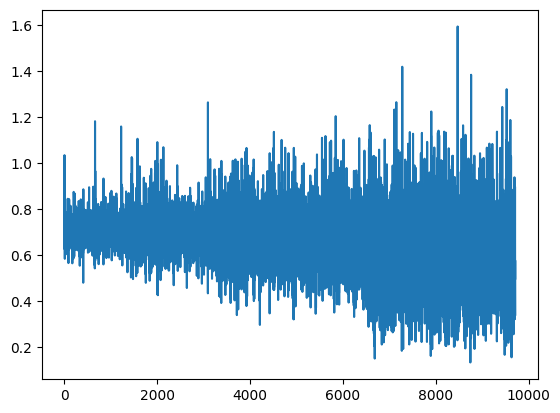

In [ ]:
from transformers import AutoTokenizer, BertForSequenceClassification
## initialize hyperparamaters
num_labels = 2
device = torch.device('cuda:0')
lr = 1e-3
readmission_mode = 'discharge'
data_dir = 'DATA/'
data_dir = os.path.join(data_dir, readmission_mode)
output_dir = 'experiment'
output_dir = os.path.join(output_dir, readmission_mode)
model = 'bert'
output_dir = os.path.join(output_dir, model)
max_seq_length = 512
train_batch_size = 8
num_train_epochs = 3
eval_batch_size = 8


# Load model, tokenizer
tokenizer = AutoTokenizer.from_pretrained("google-bert/bert-base-uncased")
model = BertForSequenceClassification.from_pretrained("google-bert/bert-base-uncased", num_labels=2)
model.to(device)

# Train
model, train_loss, global_step_check, number_training_steps = train_model(model, tokenizer, data_dir, num_labels, device, lr, train_batch_size, num_train_epochs, max_seq_length)

In [ ]:
train_result = {'global_step': global_step_check,
                'training loss': train_loss/number_training_steps}
print(train_result)

{'global_step': 9714, 'training loss': 0.5830058009766959}


In [ ]:
### save model
model_path = os.path.join(output_dir, 'model.pth')
torch.save(model, model_path)
print(f"Entire model saved to {model_path}")

Entire model saved to experiment/discharge/bert/model.pth


#### ClinicalBert-based readmission prediction

config.json:   0%|          | 0.00/385 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/436M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at emilyalsentzer/Bio_ClinicalBERT and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


LOOKING AT DATA/discharge/train.csv


103it [00:00, 508.77it/s]

*** Example ***
guid: train-0
tokens: [CLS] l ##v cavity size . normal regional l ##v s ##ys ##to ##lic function . h ##yper ##dynamic l ##ve ##f > 75 % . mid - ca ##vi ##tary gradient . no vs ##d . right vent ##ric ##le : normal r ##v chamber size and free wall motion . a ##ort ##a : mildly di ##lated ascending a ##ort ##a . a ##ort ##ic valve : three a ##ort ##ic valve leaf ##lets . moderately thick ##ened a ##ort ##ic valve leaf ##lets . mild as ( area 2 - 9 ##c ##m ##2 ) . trace a ##r . mit ##ral valve : mildly thick ##ened mit ##ral valve leaf ##lets . severe mit ##ral an ##nu ##lar ca ##l ##ci ##fication . m ##od functional m ##s due to mac . mild to moderate ( + ) m ##r . t ##ric ##us ##pid valve : mildly thick ##ened t ##ric ##us ##pid valve leaf ##lets . no t ##s . mild t ##r . in ##det ##er ##minate p ##a s ##ys ##to ##lic pressure . pu ##lm ##onic valve / pulmonary artery : no ps . per ##ica ##rdi ##um : no per ##ica ##rdi ##al e ##ff ##usion . conclusions the left at ##rium 

26245it [00:50, 519.20it/s]


***** Running training *****
  Num examples = %d 26245
  Batch size = %d 8
  Num steps = %d 1093


Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 0, Step: 199, Loss: 0.7059447881579399, Acc: 0.503125
Epoch: 0, Step: 399, Loss: 0.702156740128994, Acc: 0.503125
Epoch: 0, Step: 599, Loss: 0.6928488352894783, Acc: 0.539375
Epoch: 0, Step: 799, Loss: 0.6822802586853505, Acc: 0.55875
Epoch: 0, Step: 999, Loss: 0.6678638717532158, Acc: 0.6
Epoch: 0, Step: 1199, Loss: 0.671190810650587, Acc: 0.605
Epoch: 0, Step: 1399, Loss: 0.6791284012794495, Acc: 0.571875
Epoch: 0, Step: 1599, Loss: 0.6785695049166679, Acc: 0.585
Epoch: 0, Step: 1799, Loss: 0.6707254929840565, Acc: 0.58625
Epoch: 0, Step: 1999, Loss: 0.6738353025913238, Acc: 0.58875
Epoch: 0, Step: 2199, Loss: 0.6708595913648605, Acc: 0.598125
Epoch: 0, Step: 2399, Loss: 0.6782568421959877, Acc: 0.5675
Epoch: 0, Step: 2599, Loss: 0.6779501619935036, Acc: 0.580625
Epoch: 0, Step: 2799, Loss: 0.680164088010788, Acc: 0.570625
Epoch: 0, Step: 2999, Loss: 0.6512766778469086, Acc: 0.634375
Epoch: 0, Step: 3199, Loss: 0.6773278100788593, Acc: 0.585625


Epoch:  33%|███▎      | 1/3 [16:04<32:08, 964.25s/it]

Epoch: 1, Step: 199, Loss: 0.6543991559743881, Acc: 0.6225
Epoch: 1, Step: 399, Loss: 0.649336453974247, Acc: 0.63
Epoch: 1, Step: 599, Loss: 0.6599100084602832, Acc: 0.611875
Epoch: 1, Step: 799, Loss: 0.6550763376057148, Acc: 0.613125
Epoch: 1, Step: 999, Loss: 0.6622349858283997, Acc: 0.618125
Epoch: 1, Step: 1199, Loss: 0.6361016644537449, Acc: 0.646875
Epoch: 1, Step: 1399, Loss: 0.6393812032043934, Acc: 0.64875
Epoch: 1, Step: 1599, Loss: 0.6350350867211819, Acc: 0.630625
Epoch: 1, Step: 1799, Loss: 0.6268374618887901, Acc: 0.65
Epoch: 1, Step: 1999, Loss: 0.6355511842668057, Acc: 0.646875
Epoch: 1, Step: 2199, Loss: 0.6189145320653915, Acc: 0.670625
Epoch: 1, Step: 2399, Loss: 0.6316927716135978, Acc: 0.649375
Epoch: 1, Step: 2599, Loss: 0.6479459816217422, Acc: 0.645
Epoch: 1, Step: 2799, Loss: 0.6203593805432319, Acc: 0.66875
Epoch: 1, Step: 2999, Loss: 0.6340703463554382, Acc: 0.644375
Epoch: 1, Step: 3199, Loss: 0.6151916499435902, Acc: 0.679375


Epoch:  67%|██████▋   | 2/3 [32:07<16:03, 963.58s/it]

Epoch: 2, Step: 199, Loss: 0.545723266005516, Acc: 0.73125
Epoch: 2, Step: 399, Loss: 0.5579022084921599, Acc: 0.734375
Epoch: 2, Step: 599, Loss: 0.5712758067250252, Acc: 0.716875
Epoch: 2, Step: 799, Loss: 0.5608686878532171, Acc: 0.715625
Epoch: 2, Step: 999, Loss: 0.5405918125808239, Acc: 0.740625
Epoch: 2, Step: 1199, Loss: 0.5555082166194916, Acc: 0.72375
Epoch: 2, Step: 1399, Loss: 0.555160164013505, Acc: 0.736875
Epoch: 2, Step: 1599, Loss: 0.571615308597684, Acc: 0.7225
Epoch: 2, Step: 1799, Loss: 0.5689281751215458, Acc: 0.72875
Epoch: 2, Step: 1999, Loss: 0.5383295487612486, Acc: 0.731875
Epoch: 2, Step: 2199, Loss: 0.5711077816784382, Acc: 0.729375
Epoch: 2, Step: 2399, Loss: 0.5328491655737162, Acc: 0.75625
Epoch: 2, Step: 2599, Loss: 0.5489953289926052, Acc: 0.73
Epoch: 2, Step: 2799, Loss: 0.5418965259194374, Acc: 0.741875
Epoch: 2, Step: 2999, Loss: 0.5359308706223964, Acc: 0.745625
Epoch: 2, Step: 3199, Loss: 0.5420929705351591, Acc: 0.74125


Epoch: 100%|██████████| 3/3 [48:11<00:00, 963.94s/it]


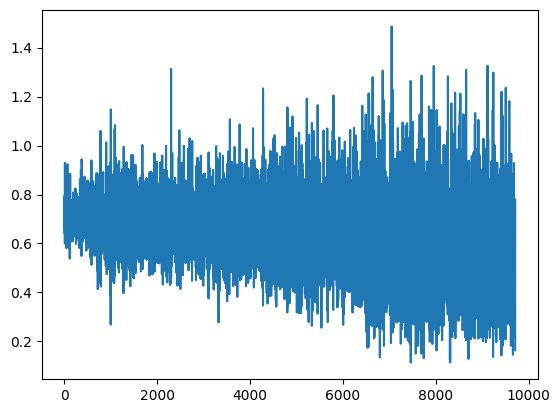

In [ ]:
from transformers import AutoTokenizer, BertForSequenceClassification
## initialize hyperparamaters
num_labels = 2
device = torch.device('cuda:0')
lr = 1e-3
readmission_mode = 'discharge'
data_dir = 'DATA/'
data_dir = os.path.join(data_dir, readmission_mode)
output_dir = 'experiment'
output_dir = os.path.join(output_dir, readmission_mode)
model = 'clinicalbert'
output_dir = os.path.join(output_dir, model)
max_seq_length = 512
train_batch_size = 8
num_train_epochs = 3
eval_batch_size = 8


# Load model, tokenizer
tokenizer = AutoTokenizer.from_pretrained("emilyalsentzer/Bio_ClinicalBERT")
model = BertForSequenceClassification.from_pretrained("emilyalsentzer/Bio_ClinicalBERT", num_labels=2)
model.to(device)

# Train
model, train_loss, global_step_check, number_training_steps = train_model(model, tokenizer, data_dir, num_labels, device, lr, train_batch_size, num_train_epochs, max_seq_length)

In [ ]:
train_result = {'global_step': global_step_check,
                'training loss': train_loss/number_training_steps}
print(train_result)

{'global_step': 9714, 'training loss': 0.551930798046231}


In [ ]:
### save model
model_path = os.path.join(output_dir, 'model.pth')
torch.save(model, model_path)
print(f"Entire model saved to {model_path}")

Entire model saved to experiment/discharge/clinicalbert/model.pth


### Hierachical Model Experiments using All Notes Cohort

For Hierachical Model, we used a different cohort compared to flat models

#### LSTM readmission prediction (no time info)

The LSTM model serves as a baseline model in hierachical models, which does not include time info. We also compare its results with FTL-Trans as a ablation study to show the effect of time info.

In [ ]:
### Follow the instructions in preprocessing_FTL_Trans.ipynb to generate DATA FILE ./DATA/readmission/, which contains train.csv, val.csv and test.csv
### Run the code below to obtain the evaluation results
!pip install pytorch_transformers
!pip install pytorch_pretrained_bert
!pip install dotmap

!python3 run_clbert_lstm.py --data_dir ./DATA/readmission/ --train_data train.csv --val_data val.csv --test_data test.csv --log_path ./log_readmission.txt --bert_model ./pretraining/ --embed_mode all --task_name LSTM_Prediction --max_seq_length 128 --train_batch_size 32 --eval_batch_size 1 --learning_rate 2e-5 --num_train_epochs 3 --warmup_proportion 0.1 --max_chunk_num 32 --seed 42 --gradient_accumulation_steps 1 --output_dir ./exp_LSTM --save_model

in the modeling class
05/07/2024 22:09:26 - INFO - numexpr.utils -   NumExpr defaulting to 8 threads.
New Job Start!
Data directory: ./DATA/readmission/, Directory Code: ./DATA/readmission/, Save Model: True
Output_dir: ./exp_LSTM, Task Name: LSTM_Prediction, embed_mode: all
max_seq_length: 128,  max_chunk_num: 32
train_batch_size: 32, eval_batch_size: 1
learning_rate: 2e-05, warmup_proportion: 0.1 
num_train_epochs: 3, seed: 42, gradient_accumulation_steps: 1
LSTM Model's lstm_layers: 1
config setting: 
hidden_dropout_prob: 0.1 
initializer_range: 0.02 
max_note_position_embedding: 1000 
max_chunk_position_embedding: 1000 
embed_mode: all 
layer_norm_eps: 1e-12 
hidden_size: 768 
lstm_layers: 1 
task_name: LSTM_Prediction 

Number of GPU is 1
Device Name: Tesla T4,Device Capability: (7, 5)
05/07/2024 22:09:48 - INFO - pytorch_transformers.tokenization_utils -   Model name './pretraining/' not found in model shortcut name list (bert-base-uncased, bert-large-uncased, bert-base-cased, be

#### FTL-Trans readmission prediction (with time info)

This model is the one we are tring to replicate.

In [ ]:
### Follow the instructions in preprocessing_FTL_Trans.ipynb to generate DATA FILE ./DATA/readmission/, which contains train.csv, val.csv and test.csv
### Run the code below to obtain the evaluation results
!pip install pytorch_transformers
!pip install pytorch_pretrained_bert
!pip install dotmap

!python3 run_clbert_ftlstm.py --data_dir ./DATA/readmission/ --train_data train.csv --val_data val.csv --test_data test.csv --log_path ./log_readmission.txt --bert_model ./pretraining/ --embed_mode all --task_name FTL-Trans_Prediction --max_seq_length 128 --train_batch_size 32 --eval_batch_size 1 --learning_rate 2e-5 --num_train_epochs 3 --warmup_proportion 0.1 --max_chunk_num 32 --seed 42 --gradient_accumulation_steps 1 --output_dir ./exp_FTL-Trans --save_model

in the modeling class
05/07/2024 18:54:40 - INFO - numexpr.utils -   NumExpr defaulting to 8 threads.
New Job Start! 
Data directory: ./DATA/readmission/, Directory Code: ./DATA/readmission/, Save Model: True
Output_dir: ./exp_FTL-Trans, Task Name: FTL-Trans_Prediction, embed_mode: all
max_seq_length: 128,  max_chunk_num: 32
train_batch_size: 32, eval_batch_size: 1
learning_rate: 2e-05, warmup_proportion: 0.1
num_train_epochs: 3, seed: 42, gradient_accumulation_steps: 1
FTLSTM Model's lstm_layers: 1
config setting: 
hidden_dropout_prob: 0.1 
layer_norm_eps: 1e-12 
initializer_range: 0.02 
max_note_position_embedding: 1000 
max_chunk_position_embedding: 1000 
embed_mode: all 
hidden_size: 768 
lstm_layers: 1 
task_name: FTL-Trans_Prediction 

Number of GPU is 1
Device Name: Tesla T4,Device Capability: (7, 5)
05/07/2024 18:55:07 - INFO - pytorch_transformers.tokenization_utils -   Model name './pretraining/' not found in model shortcut name list (bert-base-uncased, bert-large-uncased, be

#### FTL-Trans readmission prediction (slightly adjust time decay function)

As the FTL-Trans above shows a poor result (accuracy = 0.5), we investigated the root cause, which is the flexible time decaying function. The explanation is covered in details in the result section.

For this experiment, we set the delta t = 1 as a constant rather than the intervals between two adjacent chunks.

In [ ]:
### Follow the instructions in preprocessing_FTL_Trans.ipynb to generate DATA FILE ./DATA/readmission/, which contains train.csv, val.csv and test.csv
### Run the code below to obtain the evaluation results
!pip install pytorch_transformers
!pip install pytorch_pretrained_bert
!pip install dotmap

!python3 run_clbert_ftlstm_test.py --data_dir ./DATA/readmission/ --train_data train.csv --val_data val.csv --test_data test.csv --log_path ./log_readmission.txt --bert_model ./pretraining/ --embed_mode all --task_name FTL-Trans_Prediction_test --max_seq_length 128 --train_batch_size 32 --eval_batch_size 1 --learning_rate 2e-5 --num_train_epochs 3 --warmup_proportion 0.1 --max_chunk_num 32 --seed 42 --gradient_accumulation_steps 1 --output_dir ./exp_FTL-Trans_test --save_model

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.4/176.4 kB 5.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.3/139.3 kB 11.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 897.5/897.5 kB 15.6 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-ma

####  Hierachical BERT Readmission Prediction

In [ ]:

readmission_mode = 'discharge'
data_dir = 'DATA/'
data_dir = os.path.join(data_dir, readmission_mode)
output_dir = 'experiment'
output_dir = os.path.join(output_dir, readmission_mode)
model = 'hierachical_bert'
output_dir = os.path.join(output_dir, model)

num_epoch = 2
lr = 1e-4
from transformers.optimization import Adafactor, AdafactorSchedule
optimizer = Adafactor(params = hierachical_bert.parameters(), lr=lr, relative_step=False)
criteria = nn.CrossEntropyLoss()


_DIR = 'DATA/'
import json
train_dir = _DIR + 'discharge/train.json'
val_dir = _DIR + 'discharge/val.json'
test_dir = _DIR + 'discharge/test.json'


train = json.load(open(train_dir))
val = json.load(open(val_dir))
test = json.load(open(test_dir))

def flatten_list_of_list_of_tokens(list_of_list_of_tokens):
    return [item for sublist in list_of_list_of_tokens for item in sublist]


def list_of_tokens_to_tensor(list_of_tokens):
    max_len = max([len(item) for item in list_of_tokens])
    res = torch.zeros(len(list_of_tokens), max_len, dtype=torch.long)
    attention_mask = torch.zeros(len(list_of_tokens), max_len, dtype=torch.long)
    for i, item in enumerate(list_of_tokens):
        res[i, :len(item)] = torch.tensor(item)
        attention_mask[i, :len(item)] = 1
    return res, attention_mask


all_losses = []
all_acc = []
for epoch in range(num_epoch):
    for i, item in enumerate(tqdm(train)):
        all_tokens = flatten_list_of_list_of_tokens(item['tokens'])
        all_tokens, attention_mask = list_of_tokens_to_tensor(all_tokens)
        label = torch.tensor([int(item['Label'])]).to(device)
        outputs = hierachical_bert(all_tokens.to(device), attention_mask.to(device))
        loss = criteria(outputs, label)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        all_losses.append(loss.item())
        all_acc.append((outputs.argmax(-1)[0] == label).item())
        if i % 500 == 0:
            print(f'train loss: {sum(all_losses[-200:])/len(all_losses[-200:])}, acc: {sum(all_acc[-200:])/len(all_acc[-200:])}')

model_path = os.path.join(output_dir, 'hierachical_bert.pth')
torch.save(model, model_path)
print(f"hierachical_bert saved to {model_path}")

# Evaluation
#### Accuracy
#### AUROC (Area under the Receiver Operating Characteristic Curve):
The area beneath the curve illustrating the true positive rate versus the false positive rate.
#### AUPRC (Area under the Precision-Recall Curve):
The area beneath the plot of precision against recall, depicting the trade-off between the two metrics.
#### RP80 (Recall at Precision of 80%):
Represents the recall achieved when precision reaches 80%, especially significant in reducing false positives for readmission prediction.

### Bert-based readmission prediction using discharge summary

0it [00:00, ?it/s]Token indices sequence length is longer than the specified maximum sequence length for this model (728 > 512). Running this sequence through the model will result in indexing errors
90it [00:00, 446.74it/s]

*** Example ***
guid: test-0
tokens: [CLS] date of birth : sex : f service : medicine all ##er ##gies : hal ##do ##l attending : chief complaint : delta ms , let ##har ##gy , ? sep ##sis . major surgical or invasive procedure : none history of present illness : h ##x obtained per ed notes and sister . hp ##i : 35 ##f with disease who presented today from day ##care after her healthcare providers noted that she was let ##har ##gic . they were initially unable to obtain a blood pressure . the patient was noted to have a very rapid heart rate . vital ##s were finally obtained and were as follows : bp 70 / 50 ( baseline sb ##ps 80 - 90 ) , hr 113 , o ##2 sat 99 % on 3 ##l nc . . the patient was transferred to where she was noted to have a te ##mp of 4 , hr 200 and sb ##p 80s . ek ##g was noteworthy for a wide complex ta ##chy ##card ##ia . the patient received aden ##osi ##ne 6 ##mg and then 12 ##mg with no improvement . she was card ##io ##verted into sin ##us rhythm . her d - dime ##r wa

3063it [00:06, 446.38it/s]


***** Running evaluation *****
  Num examples = %d 3063
  Batch size = %d 8


100%|██████████| 383/383 [01:43<00:00,  3.70it/s]


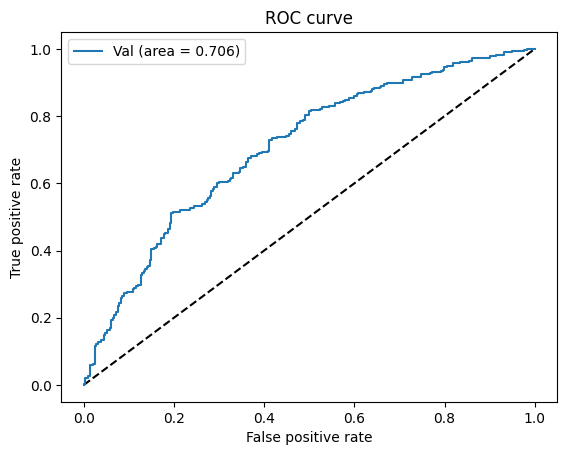

Recall at Precision of 80 is {} 0.12758620689655173


<Figure size 640x480 with 0 Axes>

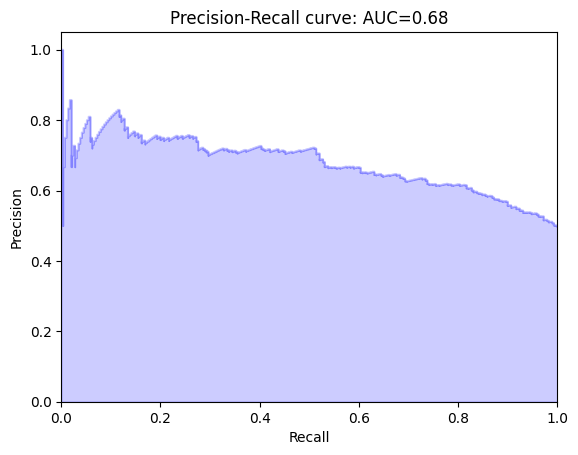

In [ ]:
# Evaluate bert-based readmission prediction using discharge summary
from transformers import AutoTokenizer, BertForSequenceClassification
## initialize hyperparamaters
device = torch.device('cuda:0')
readmission_mode = 'discharge'
data_dir = 'DATA/'
data_dir = os.path.join(data_dir, readmission_mode)
output_dir = 'experiment'
output_dir = os.path.join(output_dir, readmission_mode)
model = 'bert'
output_dir = os.path.join(output_dir, model)
max_seq_length = 512
eval_batch_size = 8

model_dir = 'experiment/discharge/bert/model.pth'
bert_discharge_model = torch.load(model_dir)
tokenizer = AutoTokenizer.from_pretrained("google-bert/bert-base-uncased")

bert_discharge_results = evaluate_model(bert_discharge_model, tokenizer, data_dir, max_seq_length, eval_batch_size, device,readmission_mode, output_dir)

In [ ]:
print(bert_discharge_results)

{'eval_loss': 0.7107204684778542, 'eval_accuracy': 0.6072477962781586, 'auc_score': 0.6502302314565969, 'auprc_score': 0.6816921470562338, 'RP80': 0.12758620689655173}


### ClinicalBert-based readmission prediction using discharge summary

82it [00:00, 407.68it/s]

*** Example ***
guid: test-0
tokens: [CLS] date of birth : sex : f service : medicine all ##er ##gies : ha ##ldo ##l attending : chief complaint : delta m ##s , let ##har ##gy , ? se ##psis . major surgical or invasive procedure : none history of present illness : h ##x obtained per ed notes and sister . hp ##i : 35 ##f with disease who presented today from day ##care after her healthcare providers noted that she was let ##har ##gic . they were initially unable to obtain a blood pressure . the patient was noted to have a very rapid heart rate . vital ##s were finally obtained and were as follows : b ##p 70 / 50 ( base ##line s ##b ##ps 80 - 90 ) , h ##r 113 , o ##2 sat 99 % on 3 ##l n ##c . . the patient was transferred to where she was noted to have a te ##mp of 4 , h ##r 200 and s ##b ##p 80s . e ##k ##g was noteworthy for a wide complex ta ##chy ##card ##ia . the patient received ad ##eno ##sin ##e 6 ##m ##g and then 12 ##m ##g with no improvement . she was card ##io ##verted into s

3063it [00:07, 406.93it/s]


***** Running evaluation *****
  Num examples = %d 3063
  Batch size = %d 8


100%|██████████| 383/383 [01:43<00:00,  3.68it/s]


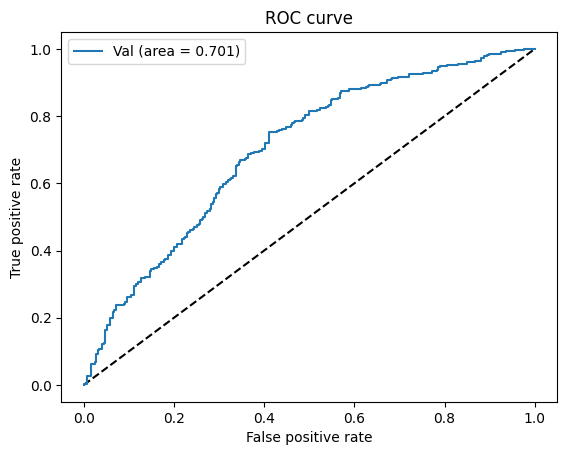

Recall at Precision of 80 is {} 0.027586206896551724


<Figure size 640x480 with 0 Axes>

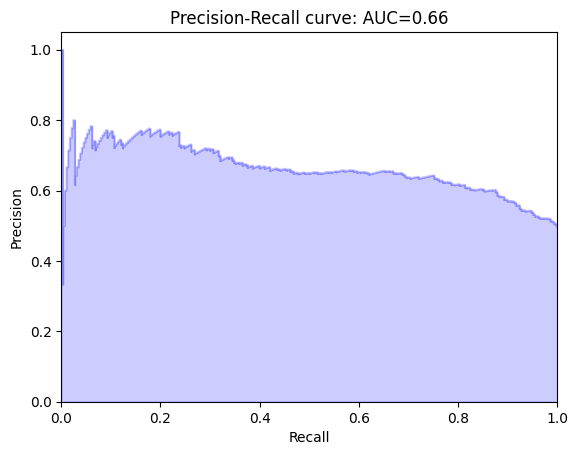

In [ ]:
# Evaluate bert-based readmission prediction using discharge summary
from transformers import AutoTokenizer, BertForSequenceClassification
## initialize hyperparamaters
device = torch.device('cuda:0')
readmission_mode = 'discharge'
data_dir = 'DATA/'
data_dir = os.path.join(data_dir, readmission_mode)
output_dir = 'experiment'
output_dir = os.path.join(output_dir, readmission_mode)
model = 'clinicalbert'
output_dir = os.path.join(output_dir, model)
max_seq_length = 512
eval_batch_size = 8

model_dir = 'experiment/discharge/clinicalbert/model.pth'
clinicalbert_discharge_model = torch.load(model_dir)
tokenizer = AutoTokenizer.from_pretrained("emilyalsentzer/Bio_ClinicalBERT")

clinicalbert_discharge_results = evaluate_model(clinicalbert_discharge_model, tokenizer, data_dir, max_seq_length, eval_batch_size, device,readmission_mode, output_dir)

In [ ]:
print(clinicalbert_discharge_results)

{'eval_loss': 0.8172822113953745, 'eval_accuracy': 0.6199804113614104, 'auc_score': 0.6390223553579609, 'auprc_score': 0.6624124970453183, 'RP80': 0.027586206896551724}


## Hierachical BERT Readmission Prediction

In [ ]:
# Evaluate bert-based readmission prediction using discharge summary
from transformers import AutoTokenizer, BertForSequenceClassification


_DIR = 'DATA/'
import json
train_dir = _DIR + 'discharge/train.json'
val_dir = _DIR + 'discharge/val.json'
test_dir = _DIR + 'discharge/test.json'


test = json.load(open(test_dir))

## initialize hyperparamaters
device = torch.device('cuda:0')
readmission_mode = 'discharge'
data_dir = 'DATA/'
data_dir = os.path.join(data_dir, readmission_mode)
output_dir = 'experiment'
output_dir = os.path.join(output_dir, readmission_mode)
model = 'hierachical_bert'
output_dir = os.path.join(output_dir, model)
max_seq_length = 512
eval_batch_size = 8

model_dir = 'experiment/discharge/hierachical_bert/hierachical_bert.pth'
hierachical_bert = torch.load(model_dir)

hierachical_bert_results = evaluate_hierachical(test)
print(hierachical_bert_results)

## LSTM readmission prediction using all notes

In [ ]:
## Test Patient Level Accuracy: 0.5775
## Test Patient Level F1 Score: 0.6442105263157896
## Test Patient Level Precision: 0.5563636363636364
## Test Patient Level Recall: 0.765
## Test Patient Level AUC: 0.6080749999999999
## Test Patient Level Matthew's correlation coefficient: 0.16720156589088403
## Test Patient Level AUPR: 0.5825588122450577

## FTL-Trans readmission prediction using all notes
We refer the reader to the readme file of our github repo for instruction on running experiments with FTL-Trans

In [ ]:
## The experiment results can be found in preprocessing_FTL_Trans.ipynb
## Test Patient Level Accuracy: 0.503957783641161
## Test Patient Level F1 Score: 0.6701754385964912
## Test Patient Level Precision: 0.503957783641161
## Test Patient Level Recall: 1.0
## Test Patient Level AUC: 0.5
## Test Patient Level Matthew's correlation coefficient: 0.0
## Test Patient Level AUPR: 0.7519788918205805

## FTL-Trans Readmission Prediction using All Notes (adjust time decay function)

In [ ]:
## Test Patient Level Accuracy: 0.5883905013192612
## Test Patient Level F1 Score: 0.5894736842105263
## Test Patient Level Precision: 0.5925925925925926
## Test Patient Level Recall: 0.5863874345549738
## Test Patient Level AUC: 0.5945750250640526
## Test Patient Level Matthew's correlation coefficient: 0.17680804262056563
## Test Patient Level AUPR: 0.5529735214178602

# Results
We report our results with our baselines BERT and ClinicalBERT as the following (in case the experiment excution above can't be finished on time)

We also report partial results running using FLT-Trans repos. However, we haven't finished all metrics, so we report with limited results.



### Result 1: Bert v.s. ClinicalBert
Beyond the original paper, we conduct experiments of Bert v.s. ClinicalBert on Readmission Prediction using Discharge Summaries.

Our experiments shows
```
Bert:
{'eval_accuracy': 0.6072477962781586,
  'auc_score': 0.6502302314565969,
  'auprc_score': 0.6816921470562338,
  'RP80': 0.12758620689655173}

ClinicalBert:
{'eval_accuracy': 0.6199804113614104,
'auc_score': 0.6390223553579609,
'auprc_score': 0.6624124970453183,
'RP80': 0.027586206896551724}
```
**The ClinicalBert outperforms Bert in terms of eval_accuracy, showing that ClinicalBert has better performance on health related data compared to Bert.**





### Result 2: Replicate FTL-Trans
To reproduce the result of original paper, we conduct experiments of FTL-Trans using All Notes. However, we get results:
```
Test Patient Level Accuracy: 0.503957783641161
Test Patient Level F1 Score: 0.6701754385964912
Test Patient Level Precision: 0.503957783641161
Test Patient Level Recall: 1.0
Test Patient Level AUC: 0.5
Test Patient Level Matthew's correlation coefficient: 0.0
Test Patient Level AUPR: 0.7519788918205805
```
The Accuracy is only ~0.5, showing that the model barely outperforms a random guess.

### Result 3: (Ablation Study 1) Adjust FTL-Trans
Upon Investigation, we found that this is due to inappropriate use of time decay function.    
The paper divides each patient's note into multiple chunks, with the time for each chunk being the same. The delta t in the time decay function is the time interval between adjacent chunks. Consequently, we will inevitably get many zeros. These zeros, in the g(delta t) function of the FTL model, will appear in the denominator, leading to incorrect results.  
To test our hypothesis, we run another experiment that simply set delta t = 1 as a constant, which yields a better result.
```
Test Patient Level Accuracy: 0.5883905013192612
Test Patient Level F1 Score: 0.5894736842105263
Test Patient Level Precision: 0.5925925925925926
Test Patient Level Recall: 0.5863874345549738
Test Patient Level AUC: 0.5945750250640526
Test Patient Level Matthew's correlation coefficient: 0.17680804262056563
Test Patient Level AUPR: 0.5529735214178602
```
**We could see Accuracy increases from 0.5 to 0.588 by only setting delta t = 1. It seems that by adjusting the delta t in an appropriate manner, we could see FTL-Trans outperforms ClinicalBert.**

### Result 4: (Ablation Study 2) LSTM v.s. FTL-Trans
The only difference between FTL-Trans and LSTM is the inclusion of time info. Therefore, we want to test if time info helps FTL-Trans outperforms LSTM.
The LSTM shows result:
```
Test Patient Level Accuracy: 0.5775
Test Patient Level F1 Score: 0.6442105263157896
Test Patient Level Precision: 0.5563636363636364
Test Patient Level Recall: 0.765
Test Patient Level AUC: 0.6080749999999999
Test Patient Level Matthew's correlation coefficient: 0.16720156589088403
Test Patient Level AUPR: 0.5825588122450577
```
**By comparing LSTM's accuracy v.s. FTL-Trans (adjusted version), we could see FTL-Trans (accuracy=0.588) does outperform LSTM (accuracy=0.577), suggesting that time info is valuable to readmission prediction.**

### Conclusion
From the results above we observe a mild improvement on accuracy from BERT to ClinicalBERT. The RP80, however, is much different between two models. We think this is due to the representation formed by clinical BERT and the prediciton probability is more expressive than BERT. We believe this gives more room for additional layers.

The experiment between the FTL-Trans and an ablation study (for which we set override time delta) to be 1 validate our doubts on the flexible time decaying introduced in FTL-Trans as the model failed to handle the actual time delta and failed to learn any meaningful results. Also, in comparison with flat model, we also see significantly lower accuracy with FTL-Trans which is likely caused by poor implementation which we aim to fix in the future experiments.

Moreover, the ablation study of comparing LSTM and FTL-Trans shows that the time info is valuable to the prediction task. Therefore, we believe that by appropriately handle flexible time decaying introduced in FTL-Trans, we can get better predictions.


# Discussion

### Reproducibility
During our reproduction, we met two difficulties. First, the author did not publish how he preprocessed the data. The instructions are pretty vague. In fact, we refer to another paper's repo (https://github.com/kexinhuang12345/clinicalBERT/tree/master) to figure out the preprocessing steps. We also saw other people raised same issue in the repo. The second difficulty is the time decay function we discussed above.

Overall, due to the issues we mentioned in result section, we do not think the result can be reproduced. Even we fixing the implementation issues, the flexible time function introduced in FTL-Trans[1] will not work properly with the actual time different (which is 0 for most of the time).

### Recommendations
Corresponding to our two challenges, we think 2 things are important:
1. Giving clear instructions of reproducity, including data preprocessing
2. Before pushing codes to github, make sure the results is reproducible




# Github Repo
https://github.com/yitzhao/CS598_FTL_Trans

# References

[1] D. Zhang, J. Thadajarassiri, C. Sen, and E. Rundensteiner, “Timeaware transformer-based network for clinical notes series prediction,” in Machine Learning for Healthcare Conference. PMLR, Sep. 2020, pp. 566–588.

[2] Inci M Baytas, Cao Xiao, Xi Zhang, Fei Wang, Anil K Jain, and Jiayu Zhou. Patient subtyping via time-aware lstm networks. In Proceedings of the 23rd ACM SIGKDD international conference on knowledge discovery and data mining, pages 65–74. ACM, 2017.

[3] Kexin Huang, Jaan Altosaar, and Rajesh Ranganath. Clinicalbert: Modeling clinical notes and predicting hospital readmission. arXiv preprint arXiv:1904.05342, 2019.

[4] Baytas IM, Xiao C, Zhang X, Wang F, Jain AK, Zhou J. Patient subtyping via time-aware LSTM networks. In: proceedings of the 23rd ACM
SIGKDD International Conference on Knowledge Discovery and Data
Mining. Halifax, NS, Canada: ACM; 2017: 65–74.

[5] Alsentzer E, Murphy J R, Boag W, et al. Publicly available clinical
BERT embeddings. ArXiv: 1904.03323

[6] https://github.com/zdy93/FTL-Trans

[7] https://github.com/kexinhuang12345/clinicalBERT


In [ ]:
# Mount the drive
from google.colab import drive
drive.mount('/content/gdrive')

# Go to the directory where your file is
%cd /content/drive/MyDrive/FTL-\ Notebooks/

# Verify that now you see your notebooks
!ls

# Convert
!jupyter nbconvert --to pdf my_notebook.ipynb

Mounted at /content/gdrive
[Errno 107] Transport endpoint is not connected: '/content/drive/MyDrive/FTL-Trans/'
/content


In [ ]:
# %% [code]
!wget -nc https://raw.githubusercontent.com/brpy/colab-pdf/master/colab_pdf.py
from colab_pdf import colab_pdf


File ‘colab_pdf.py’ already there; not retrieving.



ValueError: file 'Project_Draft.ipynb' not found in path '/content/drive/MyDrive/Colab Notebooks/'.

In [ ]:
def colab2pdf():
    # Colab2PDF by Drengskapur (https://github.com/drengskapur/colab2pdf)
    # @title Convert Colab Notebook to PDF {display-mode:'form'}
    # VERSION 1.3
    # LICENSE: GPL-3.0-or-later
    !apt-get install -yqq --no-install-recommends librsvg2-bin>/dev/null
    import contextlib,datetime,google,io,IPython,ipywidgets,json,locale,nbformat,os,pathlib,requests,urllib,warnings,werkzeug,yaml;locale.setlocale(locale.LC_ALL,'en_US.UTF-8')
    def convert(b):
        try:
            s.value='⚙️ Converting...';b.disabled=True;get_ipython().events.register('post_execute',lambda:IPython.display.display(IPython.display.Javascript('document.querySelectorAll("#output-footer").forEach(footer=>footer.remove());')))
            n=pathlib.Path(werkzeug.utils.secure_filename(urllib.parse.unquote(requests.get(f'http://{os.environ["COLAB_JUPYTER_IP"]}:{os.environ["KMP_TARGET_PORT"]}/api/sessions').json()[0]['name'])))
            p=pathlib.Path('/content/pdfs')/f'{datetime.datetime.now().strftime("%Y%m%d_%H%M%S")}_{n.stem}';p.mkdir(parents=True,exist_ok=True);warnings.filterwarnings('ignore',category=nbformat.validator.MissingIDFieldWarning)
            nb=[cell for cell in nbformat.reads(json.dumps(google.colab._message.blocking_request('get_ipynb',timeout_sec=600)['ipynb']),as_version=4).cells if '--Colab2PDF' not in cell.source]
            with (p/f'{n.stem}.ipynb').open('w',encoding='utf-8') as cp:nbformat.write(nbformat.v4.new_notebook(cells=nb or [nbformat.v4.new_code_cell('#')]),cp)
            with (p/'config.yml').open('w',encoding='utf-8') as f:yaml.dump({'include-in-header':[{'text':r'\usepackage{fvextra}\DefineVerbatimEnvironment{Highlighting}{Verbatim}{breaksymbolleft={},showspaces=false,showtabs=false,breaklines,breakanywhere,commandchars=\\\{\}}'}],'include-before-body':[{'text':r'\DefineVerbatimEnvironment{verbatim}{Verbatim}{breaksymbolleft={},showspaces=false,showtabs=false,breaklines}'}]},f)
            !quarto render {p}/{n.stem}.ipynb --metadata-file={p}/config.yml --to pdf -M latex-auto-install -M margin-top=1in -M margin-bottom=1in -M margin-left=1in -M margin-right=1in --quiet
            google.colab.files.download(str(p/f'{n.stem}.pdf'));s.value=f'🎉 Downloaded {n.stem}.pdf'
        except Exception as e:
            s.value=f'⚠️ ERROR {str(e)}'
        finally:
            b.disabled=False
    if not pathlib.Path('/usr/local/bin/quarto').exists():
        !wget -q 'https://quarto.org/download/latest/quarto-linux-amd64.deb' -P {p} && dpkg -i {p}/quarto-linux-amd64.deb>/dev/null && quarto install tinytex --update-path --quiet
    b=ipywidgets.widgets.Button(description='⬇️ Download PDF');s=ipywidgets.widgets.Label();b.on_click(lambda b:convert(b));IPython.display.display(ipywidgets.widgets.HBox([b,s]))
    IPython.display.display(IPython.display.Javascript('document.currentScript.parentElement.closest(".output_subarea").querySelector("#output-footer > input").remove();'))
colab2pdf()

<IPython.core.display.Javascript object>

/bin/bash: line 1: quarto: command not found


<IPython.core.display.Javascript object>

/bin/bash: line 1: quarto: command not found


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>